In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from prince import FAMD
from scipy import sparse
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import os


In [3]:
def encoder(df, col_split):
    """
    Prepares the data for the model by standardizing the continuous features, 
    converting the categorical features to strings, 
    and converting sparse columns to a dense format for FAMD.
    """
    categorical_cols = df.columns[:col_split]

    # converting the categorical features to strings
    df[categorical_cols] = df[categorical_cols].astype(str)

    return df

def load_data(data_address='beta_dates/beta_data_7_60.csv', label_address='beta_dates/true_labels.csv'):
    df = pd.read_csv(data_address, index_col=0)
    y = pd.read_csv(label_address, index_col=0).values[:,0]
    y = y + 1
    X = encoder(df, 4)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

    return X_train, X_test, y_train, y_test
def load_data_cv(data_address='beta_dates/beta_data_7_60.csv', label_address='beta_dates/true_labels.csv'):
    df = pd.read_csv(data_address, index_col=0)
    y = pd.read_csv(label_address, index_col=0).values[:,0]
    y = y + 1
    X = encoder(df, 4)

    return X, y

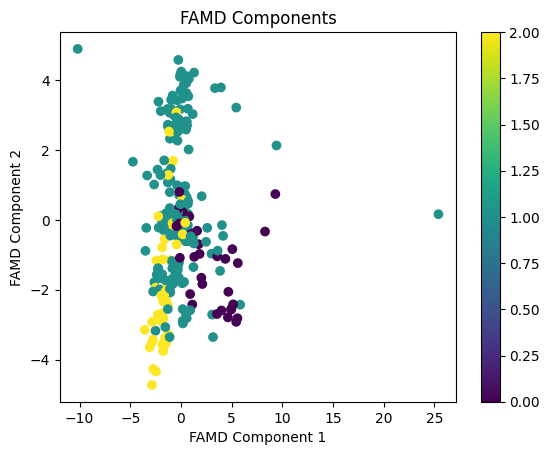

In [8]:
X, y = load_data_cv()

# Perform FAMD with 2 components
famd = FAMD(n_components=2, n_iter=10, copy=True, check_input=True, engine='sklearn', random_state=42)
famd.fit(X)
X_famd = famd.transform(X)

# Plot the first two components
plt.scatter(X_famd.iloc[:, 0], X_famd.iloc[:, 1], c=y)  # Use .iloc for DataFrame indexing
plt.xlabel('FAMD Component 1')
plt.ylabel('FAMD Component 2')
plt.title('FAMD Components')
# show the color legend
plt.colorbar()
plt.show()

# XGBoost Random Search

In [9]:
# X_train, X_test, y_train, y_test = load_data()
# # create a pipeline for XGBoost, SVD, and RandomizedSearchCV
# pipe = Pipeline([
#         ('famd', FAMD()),
#         ('xgb', xgb.XGBClassifier(objective='multi:softmax', random_state=42)),
#         ])

# # create a parameter grid for the pipeline
# param_grid = {
#         'famd__n_components': [3,4,5],
#         'xgb__gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
#         'xgb__learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
#         'xgb__max_depth': [5,6,7,8,9,10,11,12,13,14],
#         'xgb__n_estimators': [50,65,80,100,115,130,150],
#         'xgb__reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
#         'xgb__reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
#         'xgb__subsample': [0.5,0.6,0.7,0.8,0.9,1],
#         'xgb__colsample_bytree': [0.5,0.6,0.7,0.8,0.9,1],
#         'xgb__min_child_weight': [0.5,1,3,5,7,9],
#               }

# # perform random search

# random_search = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, cv=7, scoring='accuracy', verbose=1, n_jobs=-1, n_iter=1000)
# random_search.fit(X_train, y_train)

# # train model with best parameters
# best_model = random_search.best_estimator_
# best_model.fit(X_train, y_train)

# # Predictions
# predictions = best_model.predict(X_test)

# # Evaluation
# print(classification_report(y_test, predictions))

# print(random_search.best_params_)
# print(random_search.best_score_)
# print(random_search.cv_results_)

# XGBoost Bayesian Optimization

In [74]:
X_train, X_test, y_train, y_test = load_data()

# Create a pipeline
pipe = Pipeline([
    ('svd', FAMD(n_components=3)),
    ('xgb', XGBClassifier(objective='multi:softmax', random_state=42)),
])

# Define the evaluation function
def xgb_evaluate(gamma, learning_rate, max_depth, n_estimators, reg_alpha, reg_lambda, subsample, colsample_bytree, min_child_weight):
    params = {
        'xgb__gamma': gamma,
        'xgb__learning_rate': learning_rate,
        'xgb__max_depth': int(max_depth),
        'xgb__n_estimators': int(n_estimators),
        'xgb__reg_alpha': reg_alpha,
        'xgb__reg_lambda': reg_lambda,
        'xgb__subsample': subsample,
        'xgb__colsample_bytree': colsample_bytree,
        'xgb__min_child_weight': min_child_weight,
    }
    pipe.set_params(**params)
    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    return accuracy_score(y_test, predictions)

# Bayesian Optimization
optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds={
        'gamma': (0, 5),
        'learning_rate': (0.01, 0.5),
        'max_depth': (3, 5),
        'n_estimators': (50, 300),
        'reg_alpha': (10, 100),
        'reg_lambda': (10, 100),
        'subsample': (0.5, 1.0),
        'colsample_bytree': (0.5, 1.0),
        'min_child_weight': (1, 10),
    },
    random_state=42
)

optimizer.maximize(init_points=5, n_iter=200)

# After optimization, retrieve and adjust best parameters for pipeline
xgb_best_params = optimizer.max['params']
xgb_best_params_for_pipeline = {'xgb__' + key: int(value) if key in ['max_depth', 'n_estimators'] else value for key, value in xgb_best_params.items()}

# Set the best parameters in the pipeline
pipe.set_params(**xgb_best_params_for_pipeline)
pipe.fit(X_train, y_train)

# Predictions and Evaluation
predictions = pipe.predict(X_test)
print(classification_report(y_test, predictions))

# Print best parameters and performance
print("Best Parameters for Pipeline:", xgb_best_params_for_pipeline)
print("Best Performance:", optimizer.max['target'])



|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.6812    | 0.6873    | 4.754     | 0.3687    | 4.197     | 2.404     | 89.0      | 15.23     | 87.96     | 0.8006    |
| 2         | 0.6812    | 0.854     | 0.1029    | 0.4853    | 4.665     | 2.911     | 95.46     | 26.51     | 37.38     | 0.7624    |
| 3         | 0.6812    | 0.716     | 1.456     | 0.3098    | 3.279     | 3.629     | 141.6     | 51.05     | 80.67     | 0.5998    |
| 4         | 0.1159    | 0.7571    | 2.962     | 0.03276   | 4.215     | 2.535     | 66.26     | 95.4      | 96.91     | 0.9042    |
| 5         | 0.6812    | 0.6523    | 0.4884    | 0.3453    | 3.88      | 2.098     | 173.8     | 13.09     | 91.84     | 0.6294    |
| 6         | 0.6812    | 1.0       | 5.0       | 0.01      | 

# Build the best model

{'logreg__C': 32.67792536975631, 'logreg__penalty': 'l2', 'logreg__multi_class': 'ovr', 'logreg__solver': 'saga'}


In [84]:
# Number of splits for K-Fold Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

X, y = load_data_cv()

famd = FAMD(n_components=8)
famd.fit(X)
X = famd.transform(X)

# create a pipeline with the best parameters
pipe = Pipeline([
    ('xgb', XGBClassifier(objective='multi:softmax')),
])

def xgb_evaluate(gamma, learning_rate, max_depth, n_estimators, reg_alpha, reg_lambda, subsample, colsample_bytree, min_child_weight):
    params = {
        'xgb__gamma': gamma,
        'xgb__learning_rate': learning_rate,
        'xgb__max_depth': int(max_depth),
        'xgb__n_estimators': int(n_estimators),
        'xgb__reg_alpha': reg_alpha,
        'xgb__reg_lambda': reg_lambda,
        'xgb__subsample': subsample,
        'xgb__colsample_bytree': colsample_bytree,
        'xgb__min_child_weight': min_child_weight,
    }
    pipe.set_params(**params)
    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    return accuracy_score(y_test, predictions)

# Perform K-Fold Cross-Validation

accuracy_scores = []
params = []
for train_index, test_index in skf.split(X, y):

    # Bayesian Optimization
    optimizer = BayesianOptimization(
        f=xgb_evaluate,
        pbounds={
            'gamma': (.1, 10),
            'learning_rate': (0.01, 1),
            'max_depth': (3, 6),
            'n_estimators': (80, 200),
            'reg_alpha': (.5, 10),
            'reg_lambda': (.5, 10),
            'subsample': (0.1, 1.0),
            'colsample_bytree': (0.1, 1.0),
            'min_child_weight': (3, 10),
        },
    )
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    optimizer.maximize(init_points=5, n_iter=200)

    # After optimization, retrieve and adjust best parameters for pipeline
    xgb_best_params = optimizer.max['params']
    xgb_best_params_for_pipeline = {'xgb__' + key: int(value) if key in ['max_depth', 'n_estimators'] else value for key, value in xgb_best_params.items()}

    # Set the best parameters in the pipeline
    pipe.set_params(**xgb_best_params_for_pipeline)
    pipe.fit(X_train, y_train)

    # Predictions and Evaluation
    predictions = pipe.predict(X_test)
    print(classification_report(y_test, predictions))

    # Print best parameters and performance
    print("Best Parameters for Pipeline:", xgb_best_params_for_pipeline)
    print("Best Performance:", optimizer.max['target'])

    accuracy_scores.append(optimizer.max['target'])
    params.append(xgb_best_params_for_pipeline)

print("Average Accuracy:", np.mean(accuracy_scores))


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.6909    | 0.799     | 5.118     | 0.7581    | 3.035     | 3.152     | 85.63     | 6.167     | 3.338     | 0.4266    |
| 2         | 0.6909    | 0.3695    | 5.343     | 0.3844    | 4.442     | 6.485     | 169.7     | 3.091     | 4.758     | 0.8265    |
| 3         | 0.6909    | 0.2314    | 7.419     | 0.9844    | 3.151     | 4.872     | 158.5     | 4.085     | 3.341     | 0.5814    |
| 4         | 0.6909    | 0.8069    | 8.695     | 0.7732    | 3.893     | 9.192     | 138.6     | 2.152     | 9.269     | 0.143     |
| 5         | 0.6909    | 0.2983    | 2.899     | 0.5162    | 5.807     | 8.176     | 121.8     | 2.139     | 8.181     | 0.4427    |
| 6         | 0.6909    | 0.3455    | 1.639     | 0.7177    | 

/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


| 6         | 0.6909    | 0.1848    | 7.601     | 0.3839    | 5.738     | 9.652     | 96.45     | 2.768     | 2.371     | 0.2001    |
| 7         | 0.7636    | 0.1857    | 0.3093    | 0.9838    | 4.376     | 6.93      | 135.9     | 3.229     | 7.909     | 0.9168    |
| 8         | 0.7818    | 0.1       | 0.1       | 1.0       | 5.577     | 6.11      | 135.6     | 1.287     | 6.783     | 1.0       |
| 9         | 0.8       | 0.1       | 0.1       | 1.0       | 6.0       | 3.139     | 132.1     | 0.5       | 8.201     | 1.0       |
| 10        | 0.7636    | 0.1       | 0.1       | 1.0       | 6.0       | 3.0       | 129.9     | 0.5       | 1.616     | 1.0       |
| 11        | 0.7636    | 0.1       | 6.503     | 1.0       | 6.0       | 3.0       | 133.7     | 0.5       | 8.354     | 1.0       |
| 12        | 0.7455    | 0.1759    | 0.8716    | 0.1454    | 3.853     | 3.435     | 122.8     | 0.779     | 9.456     | 0.6389    |
| 13        | 0.6909    | 0.6836    | 10.0      | 1.0       | 

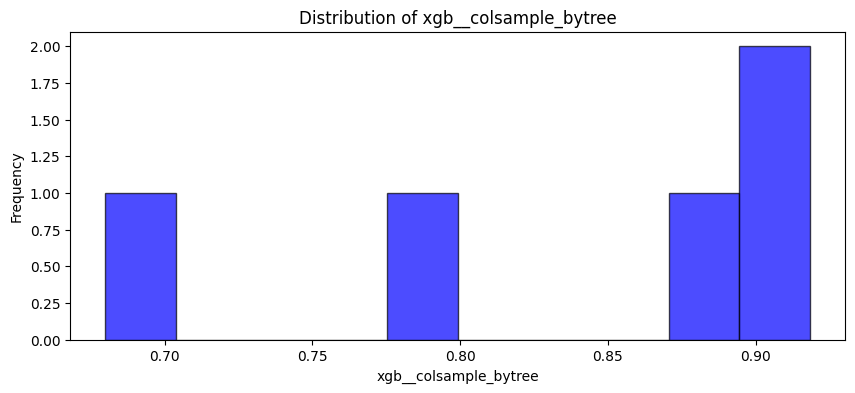

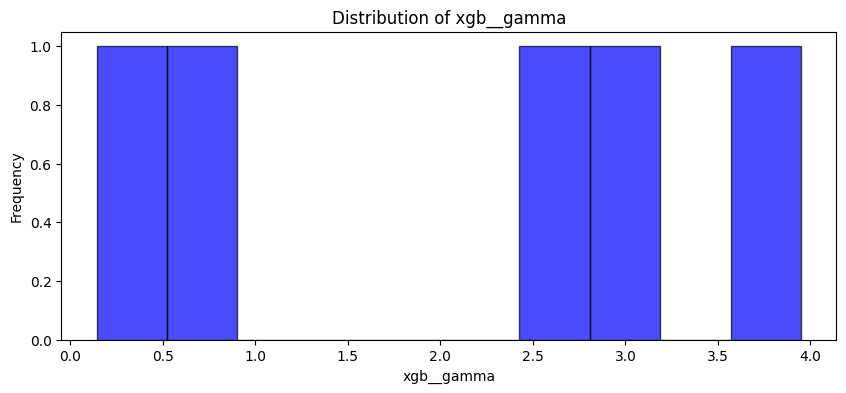

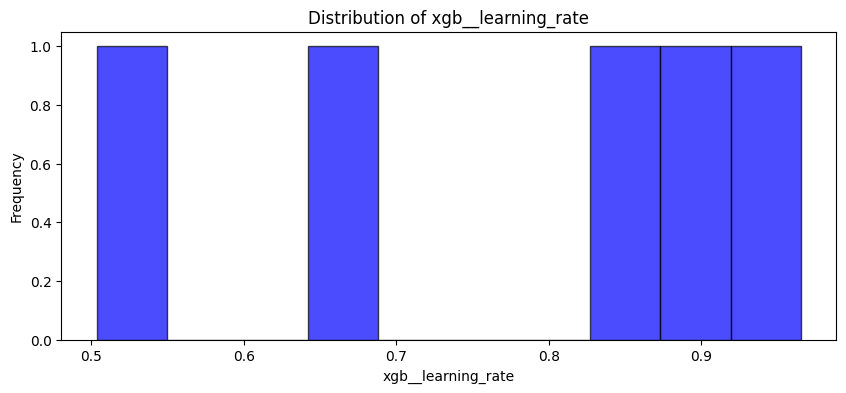

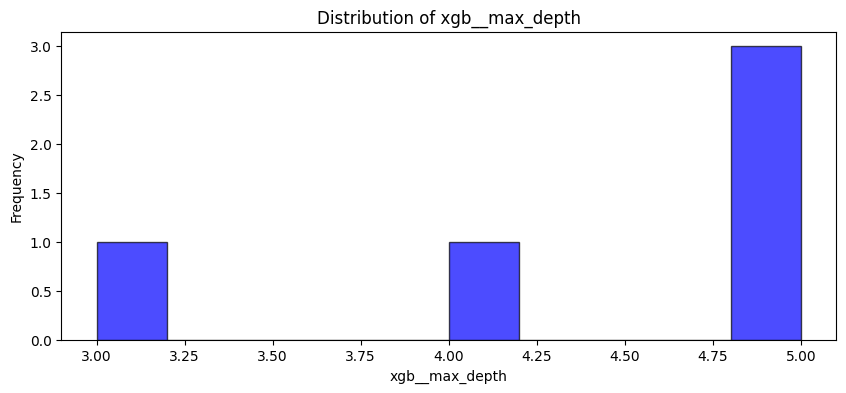

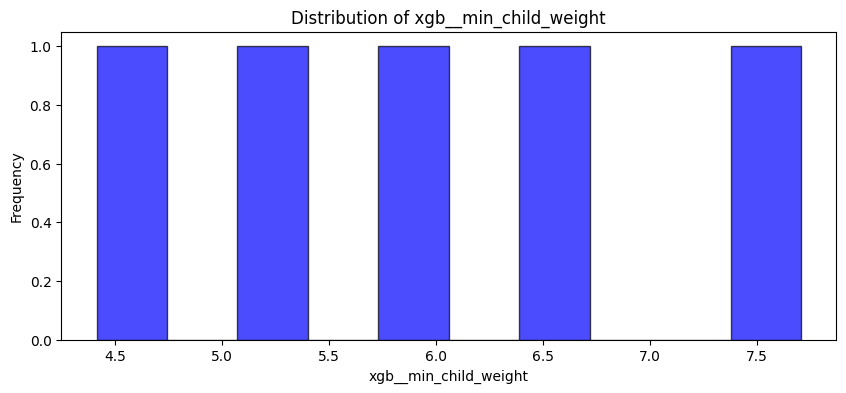

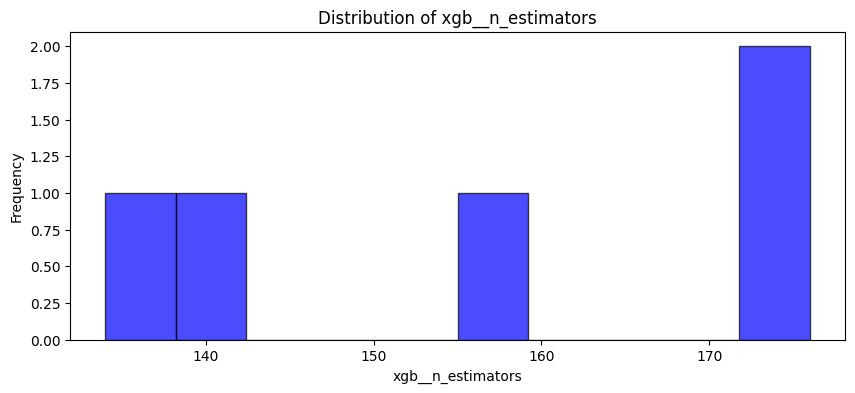

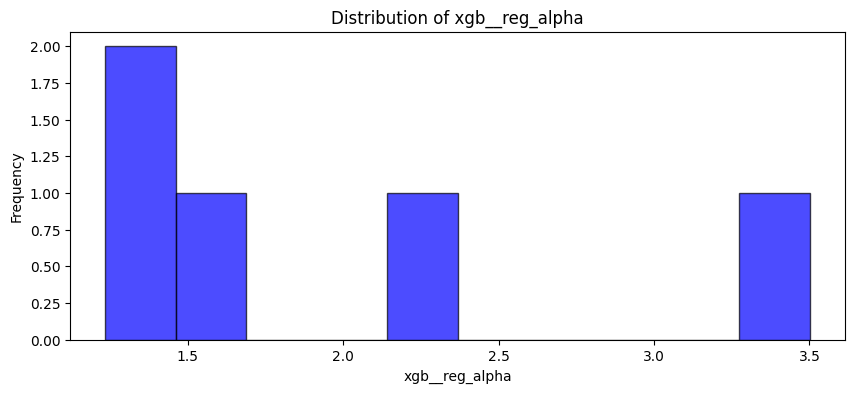

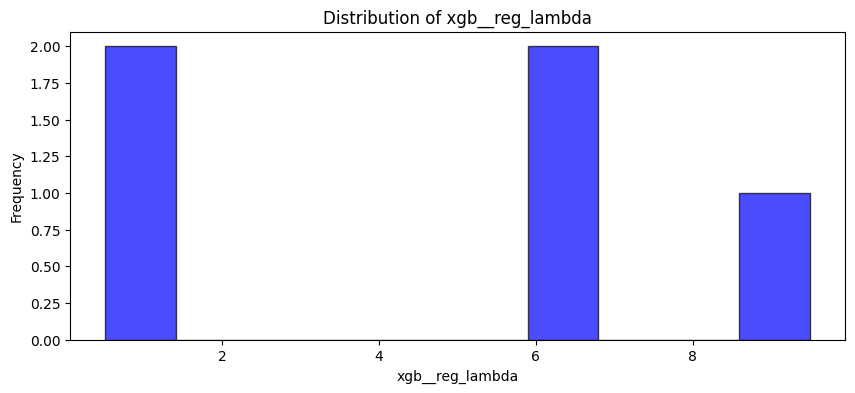

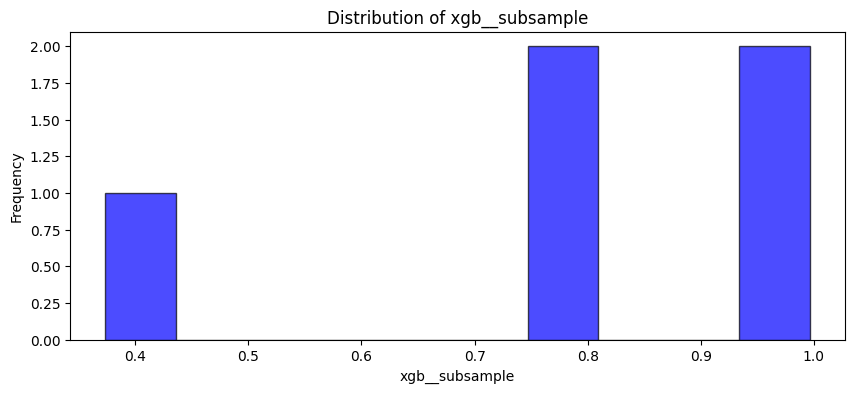

In [86]:
# create visualization of the best parameters, a visualization
param_values = {
    'xgb__colsample_bytree': [],
    'xgb__gamma': [],
    'xgb__learning_rate': [],
    'xgb__max_depth': [],
    'xgb__min_child_weight': [],
    'xgb__n_estimators': [],
    'xgb__reg_alpha': [],
    'xgb__reg_lambda': [],
    'xgb__subsample': []
}

# Populate the lists
for param_set in params:
    for param, value in param_set.items():
        param_values[param].append(value)

# Create histograms
for param, values in param_values.items():
    plt.figure(figsize=(10, 4))
    plt.hist(values, bins=10, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Distribution of {param}')
    plt.xlabel(param)
    plt.ylabel('Frequency')
    plt.show()

In [89]:
# create visualization of the best parameters, a visualization
param_values = {
    'xgb__colsample_bytree': [],
    'xgb__gamma': [],
    'xgb__learning_rate': [],
    'xgb__max_depth': [],
    'xgb__min_child_weight': [],
    'xgb__n_estimators': [],
    'xgb__reg_alpha': [],
    'xgb__reg_lambda': [],
    'xgb__subsample': []
}

# Populate the lists
for param_set in params:
    for param, value in param_set.items():
        param_values[param].append(value)

# Create histograms
for param, values in param_values.items():
    plt.figure(figsize=(10, 4))
    plt.hist(values, bins=10, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Distribution of {param}')
    plt.xlabel(param)
    plt.ylabel('Frequency')
    plt.show()
    
# Initialize a dictionary to store the sum of each parameter
sums = {
    'xgb__colsample_bytree': 0,
    'xgb__gamma': 0,
    'xgb__learning_rate': 0,
    'xgb__max_depth': 0,
    'xgb__min_child_weight': 0,
    'xgb__n_estimators': 0,
    'xgb__reg_alpha': 0,
    'xgb__reg_lambda': 0,
    'xgb__subsample': 0
}

# Sum up the values for each parameter
for param_set in params:
    for param, value in param_set.items():
        sums[param] += value

# Calculate the mean for each parameter
means = {param: sum_val / len(params) for param, sum_val in sums.items()}

# round max_depth and n_estimators
means['xgb__max_depth'] = int(round(means['xgb__max_depth']))
means['xgb__n_estimators'] = int(round(means['xgb__n_estimators']))

print("Mean values of parameters:", means)

Mean values of parameters: {'xgb__colsample_bytree': 0.8314087089720534, 'xgb__gamma': 2.068218435894297, 'xgb__learning_rate': 0.7757676744286774, 'xgb__max_depth': 4, 'xgb__min_child_weight': 5.920879982985454, 'xgb__n_estimators': 156, 'xgb__reg_alpha': 2.0124120042376505, 'xgb__reg_lambda': 4.703662676675085, 'xgb__subsample': 0.7918852620425526}


In [106]:
avg_accuracy_scores = []
for i in range(10):
    # Number of splits for K-Fold Cross-Validation
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

    X, y = load_data_cv()

    famd = FAMD(n_components=8)
    famd.fit(X)
    X = famd.transform(X)

    # create a pipeline with the best parameters
    pipe = Pipeline([
        ('xgb', XGBClassifier(objective='multi:softmax')),
    ])

    # Perform K-Fold Cross-Validation

    # set the parameters to the mean values
    pipe.set_params(**means)

    accuracy_scores = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the pipeline to the training data
        pipe.fit(X_train, y_train)

        # Make predictions on the test set
        predictions = pipe.predict(X_test)

        # Evaluate the model
        # print(classification_report(y_test, predictions))
        # print("Accuracy:", accuracy_score(y_test, predictions))
        accuracy_scores.append(accuracy_score(y_test, predictions))

    print("Average Accuracy:", np.mean(accuracy_scores))
    avg_accuracy_scores.append(np.mean(accuracy_scores))


Average Accuracy: 0.7774410774410775
Average Accuracy: 0.7482828282828283
Average Accuracy: 0.7775084175084175
Average Accuracy: 0.791986531986532
Average Accuracy: 0.7736026936026936
Average Accuracy: 0.7702356902356902
Average Accuracy: 0.7702356902356902
Average Accuracy: 0.7771717171717172
Average Accuracy: 0.7808080808080808
Average Accuracy: 0.7884848484848486
Average Accuracy: 0.7884175084175086
Average Accuracy: 0.7847811447811448
Average Accuracy: 0.7883501683501684
Average Accuracy: 0.7884175084175086
Average Accuracy: 0.76989898989899
Average Accuracy: 0.7483501683501683
Average Accuracy: 0.7845117845117846
Average Accuracy: 0.7955555555555556
Average Accuracy: 0.7661279461279461
Average Accuracy: 0.7735353535353535
Average Accuracy: 0.7773737373737374
Average Accuracy: 0.7552861952861953
Average Accuracy: 0.7703703703703704
Average Accuracy: 0.7591919191919192
Average Accuracy: 0.7517171717171717
Average Accuracy: 0.7701010101010102
Average Accuracy: 0.7517845117845118
Aver

In [109]:
print("Average Average Accuracy:", np.mean(avg_accuracy_scores))

Average Average Accuracy: 0.7716798653198653


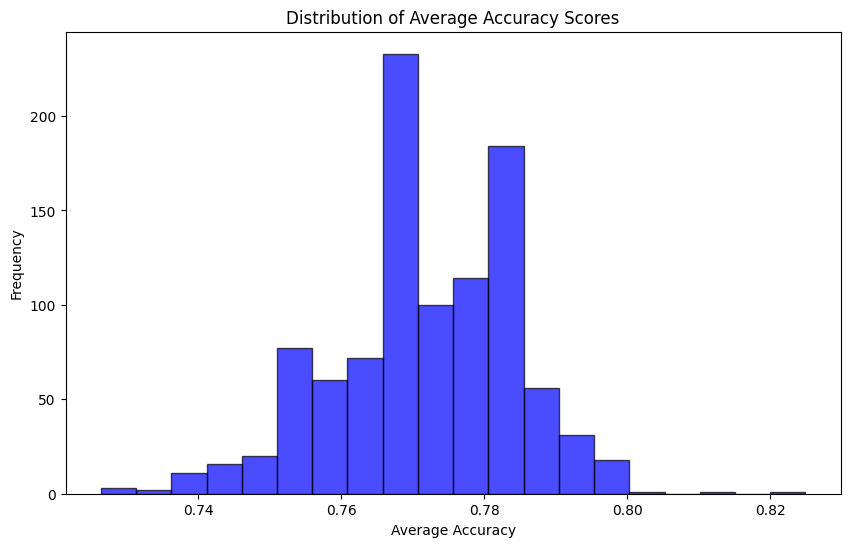

In [107]:
# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(avg_accuracy_scores, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Average Accuracy Scores')
plt.xlabel('Average Accuracy')
plt.ylabel('Frequency')
plt.show()

Average Accuracy: 0.76996632996633
Average Accuracy: 0.7592592592592593
Average Accuracy: 0.7480808080808081
Average Accuracy: 0.7592592592592593
Average Accuracy: 0.76989898989899
Average Accuracy: 0.7335353535353535
Average Accuracy: 0.7627609427609429
Average Accuracy: 0.758989898989899
Average Accuracy: 0.76996632996633
Average Accuracy: 0.780942760942761
Average Accuracy: 0.7374410774410775
Average Accuracy: 0.7703703703703704
Average Accuracy: 0.7520538720538721
Average Accuracy: 0.7479461279461279
Average Accuracy: 0.7551515151515151
Average Accuracy: 0.7698316498316499
Average Accuracy: 0.7846464646464646
Average Accuracy: 0.7773737373737373
Average Accuracy: 0.7738047138047138
Average Accuracy: 0.7808080808080808


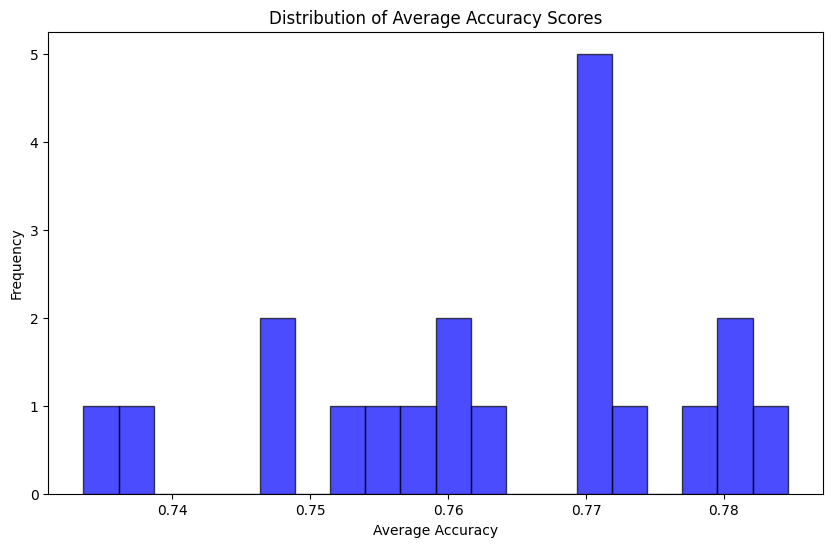

file: beta_data_2_60.csv Average Average Accuracy: 0.7631043771043771
Average Accuracy: 0.7594612794612795
Average Accuracy: 0.7514478114478115
Average Accuracy: 0.740942760942761
Average Accuracy: 0.7847811447811448
Average Accuracy: 0.7591919191919192
Average Accuracy: 0.7739393939393939
Average Accuracy: 0.7628282828282827
Average Accuracy: 0.7445791245791247
Average Accuracy: 0.7517845117845118
Average Accuracy: 0.7956228956228957
Average Accuracy: 0.7483501683501684
Average Accuracy: 0.7521212121212122
Average Accuracy: 0.7593939393939395
Average Accuracy: 0.7406734006734006
Average Accuracy: 0.7556902356902357
Average Accuracy: 0.7226262626262626
Average Accuracy: 0.7845791245791247
Average Accuracy: 0.7703030303030303
Average Accuracy: 0.7301683501683502
Average Accuracy: 0.7626936026936028


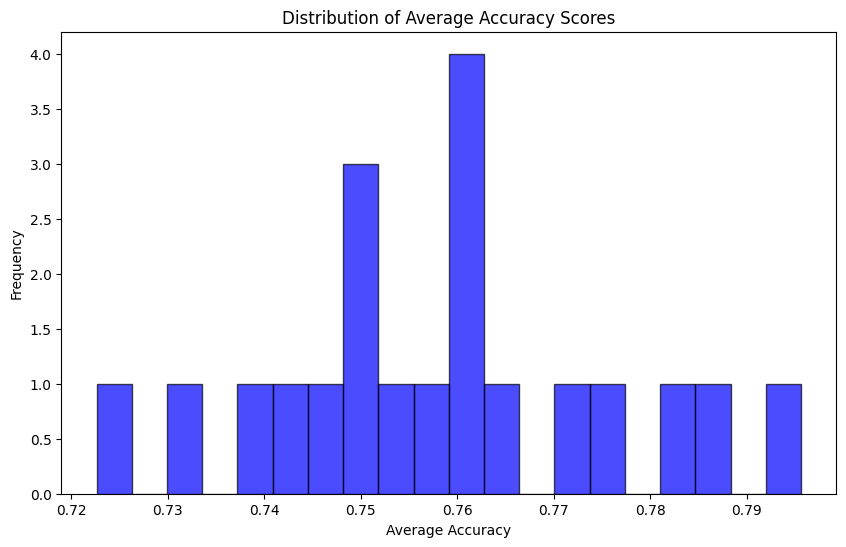

file: beta_data_7_42.csv Average Average Accuracy: 0.7575589225589225
Average Accuracy: 0.7626936026936028
Average Accuracy: 0.7813468013468015
Average Accuracy: 0.7555555555555555
Average Accuracy: 0.7518518518518519
Average Accuracy: 0.7737373737373738
Average Accuracy: 0.7556902356902357
Average Accuracy: 0.7554882154882154
Average Accuracy: 0.7554208754208753
Average Accuracy: 0.7698316498316499
Average Accuracy: 0.759057239057239
Average Accuracy: 0.7777104377104377
Average Accuracy: 0.7515824915824916
Average Accuracy: 0.7702356902356902
Average Accuracy: 0.7701683501683502
Average Accuracy: 0.7447138047138048
Average Accuracy: 0.7588552188552189
Average Accuracy: 0.7773737373737373
Average Accuracy: 0.780942760942761
Average Accuracy: 0.7517171717171718
Average Accuracy: 0.7553535353535354


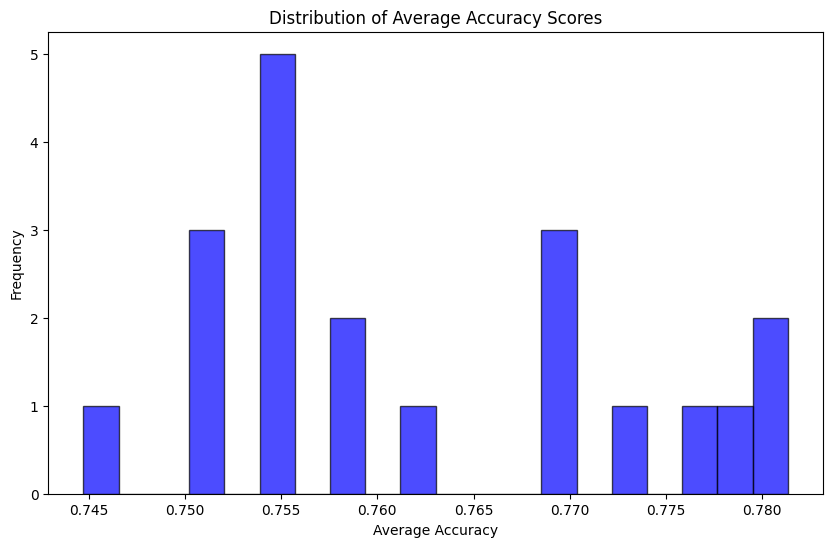

file: beta_data_7_120.csv Average Average Accuracy: 0.7629663299663301
Average Accuracy: 0.7701010101010101
Average Accuracy: 0.7663299663299663
Average Accuracy: 0.7443771043771044
Average Accuracy: 0.7371043771043773
Average Accuracy: 0.7663973063973064
Average Accuracy: 0.7588552188552188
Average Accuracy: 0.7956228956228956
Average Accuracy: 0.759057239057239
Average Accuracy: 0.7734006734006734
Average Accuracy: 0.7517845117845118
Average Accuracy: 0.7557575757575759
Average Accuracy: 0.7587205387205387
Average Accuracy: 0.7772390572390572
Average Accuracy: 0.7732659932659933
Average Accuracy: 0.7992592592592593
Average Accuracy: 0.737037037037037
Average Accuracy: 0.7737373737373737
Average Accuracy: 0.7554882154882157
Average Accuracy: 0.7589898989898991
Average Accuracy: 0.762895622895623


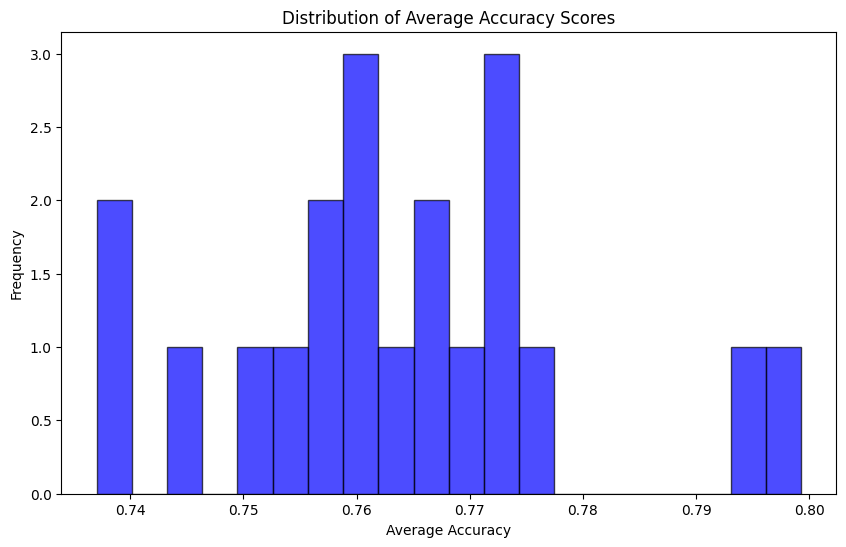

file: beta_data_2_120.csv Average Average Accuracy: 0.7637710437710439
Average Accuracy: 0.7484848484848485
Average Accuracy: 0.7919191919191919
Average Accuracy: 0.7521885521885523
Average Accuracy: 0.7810774410774411
Average Accuracy: 0.7443771043771044
Average Accuracy: 0.7630976430976432
Average Accuracy: 0.7701683501683502
Average Accuracy: 0.7517845117845118
Average Accuracy: 0.7445791245791247
Average Accuracy: 0.7738720538720539
Average Accuracy: 0.7554208754208755
Average Accuracy: 0.7481481481481481
Average Accuracy: 0.7406734006734007
Average Accuracy: 0.7665993265993267
Average Accuracy: 0.7556228956228956
Average Accuracy: 0.7626262626262627
Average Accuracy: 0.7626936026936028
Average Accuracy: 0.73003367003367
Average Accuracy: 0.781077441077441
Average Accuracy: 0.7773737373737374


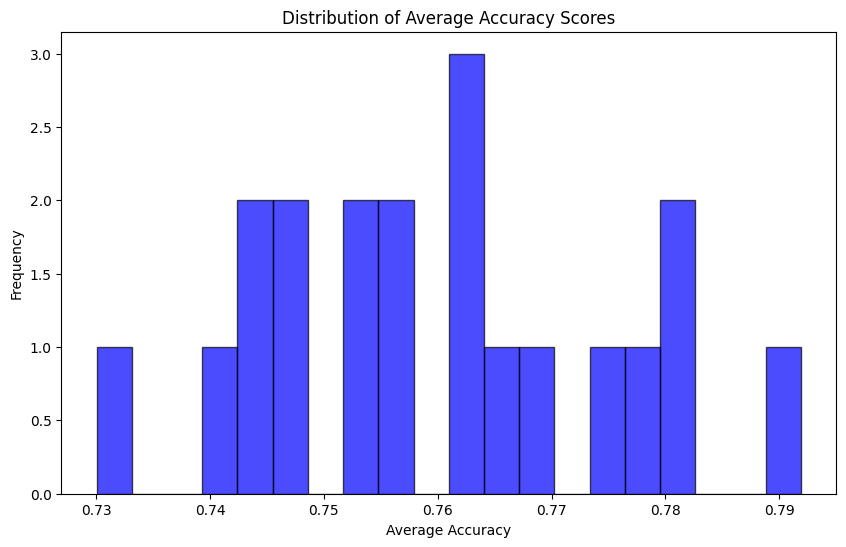

file: beta_data_2_42.csv Average Average Accuracy: 0.7600909090909092
Average Accuracy: 0.7734680134680134
Average Accuracy: 0.7957575757575758
Average Accuracy: 0.7736026936026936
Average Accuracy: 0.7301010101010101
Average Accuracy: 0.7880808080808082
Average Accuracy: 0.781010101010101
Average Accuracy: 0.7881481481481482
Average Accuracy: 0.7956228956228957
Average Accuracy: 0.7810101010101009
Average Accuracy: 0.8026936026936028
Average Accuracy: 0.759057239057239
Average Accuracy: 0.7954882154882155
Average Accuracy: 0.7775084175084175
Average Accuracy: 0.7885521885521886
Average Accuracy: 0.7701683501683502
Average Accuracy: 0.7700336700336701
Average Accuracy: 0.8065993265993265
Average Accuracy: 0.7591245791245791
Average Accuracy: 0.7737373737373737
Average Accuracy: 0.7737373737373737


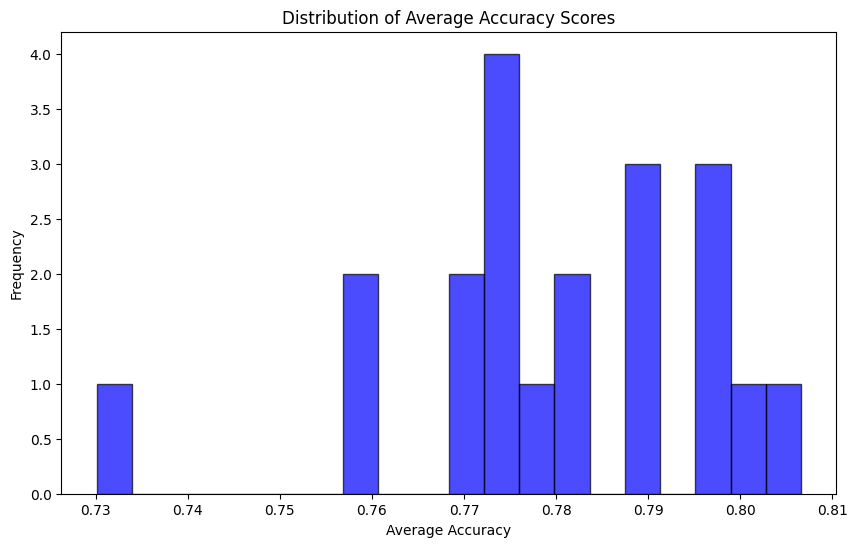

file: beta_data_7_60.csv Average Average Accuracy: 0.7791750841750843


In [15]:
# iterate for all the data files in the folder 'beta_dates
for file in os.listdir('beta_dates'):
    new_avg_accuracy_scores = []

    if file == 'true_labels.csv':
        continue

    for i in range(20):
        # Number of splits for K-Fold Cross-Validation
        n_splits = 5
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

        X, y = load_data_cv(data_address='beta_dates/' + file)
        

        famd = FAMD(n_components=8)
        famd.fit(X)
        X = famd.transform(X)

        # create a pipeline with the best parameters
        pipe = Pipeline([
            ('xgb', XGBClassifier(objective='multi:softmax')),
        ])

        # Perform K-Fold Cross-Validation

        # set the parameters to the mean values
        # pipe.set_params(**means)

        accuracy_scores = []
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Fit the pipeline to the training data
            pipe.fit(X_train, y_train)

            # Make predictions on the test set
            predictions = pipe.predict(X_test)

            # Evaluate the model
            # print(classification_report(y_test, predictions))
            # print("Accuracy:", accuracy_score(y_test, predictions))
            accuracy_scores.append(accuracy_score(y_test, predictions))

        print("Average Accuracy:", np.mean(accuracy_scores))
        new_avg_accuracy_scores.append(np.mean(accuracy_scores))
    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(new_avg_accuracy_scores, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Average Accuracy Scores')
    plt.xlabel('Average Accuracy')
    plt.ylabel('Frequency')
    plt.show()
    print("file:", file, "Average Average Accuracy:", np.mean(new_avg_accuracy_scores))

In [17]:
params = [{'xgb__colsample_bytree': 0.6798914344559404,
  'xgb__gamma': 0.6111900807705414,
  'xgb__learning_rate': 0.9655623482632335,
  'xgb__max_depth': 3,
  'xgb__min_child_weight': 5.9856706028179385,
  'xgb__n_estimators': 173,
  'xgb__reg_alpha': 2.343768219041226,
  'xgb__reg_lambda': 5.954092521623187,
  'xgb__subsample': 0.9918335379091637},
 {'xgb__colsample_bytree': 0.8749701930413057,
  'xgb__gamma': 2.7424800290020386,
  'xgb__learning_rate': 0.8653112590078486,
  'xgb__max_depth': 5,
  'xgb__min_child_weight': 6.425631563942539,
  'xgb__n_estimators': 134,
  'xgb__reg_alpha': 1.3547636408842259,
  'xgb__reg_lambda': 6.727962713158587,
  'xgb__subsample': 0.37349668583260554},
 {'xgb__colsample_bytree': 0.9182991636873359,
  'xgb__gamma': 3.9493650973216554,
  'xgb__learning_rate': 0.8733426789839808,
  'xgb__max_depth': 5,
  'xgb__min_child_weight': 4.412114640963221,
  'xgb__n_estimators': 142,
  'xgb__reg_alpha': 1.6278653616368322,
  'xgb__reg_lambda': 0.5110797712090009,
  'xgb__subsample': 0.795313325748948},
 {'xgb__colsample_bytree': 0.7813733049979861,
  'xgb__gamma': 2.8963223766940076,
  'xgb__learning_rate': 0.6711922017377561,
  'xgb__max_depth': 4,
  'xgb__min_child_weight': 5.0765372012709085,
  'xgb__n_estimators': 176,
  'xgb__reg_alpha': 1.2345833917786506,
  'xgb__reg_lambda': 0.8336261089289507,
  'xgb__subsample': 0.8024329324206352},
 {'xgb__colsample_bytree': 0.9025094486776986,
  'xgb__gamma': 0.14173459568324137,
  'xgb__learning_rate': 0.5034298841505683,
  'xgb__max_depth': 5,
  'xgb__min_child_weight': 7.704445905932663,
  'xgb__n_estimators': 155,
  'xgb__reg_alpha': 3.5010794078473175,
  'xgb__reg_lambda': 9.491552268455699,
  'xgb__subsample': 0.9963498283014104}]

sums = {
    'xgb__colsample_bytree': 0,
    'xgb__gamma': 0,
    'xgb__learning_rate': 0,
    'xgb__max_depth': 0,
    'xgb__min_child_weight': 0,
    'xgb__n_estimators': 0,
    'xgb__reg_alpha': 0,
    'xgb__reg_lambda': 0,
    'xgb__subsample': 0
}

# Sum up the values for each parameter
for param_set in params:
    for param, value in param_set.items():
        sums[param] += value

# Calculate the mean for each parameter
means = {param: sum_val / len(params) for param, sum_val in sums.items()}

# round max_depth and n_estimators
means['xgb__max_depth'] = int(round(means['xgb__max_depth']))
means['xgb__n_estimators'] = int(round(means['xgb__n_estimators']))

print("Mean values of parameters:", means)

Mean values of parameters: {'xgb__colsample_bytree': 0.8314087089720534, 'xgb__gamma': 2.068218435894297, 'xgb__learning_rate': 0.7757676744286774, 'xgb__max_depth': 4, 'xgb__min_child_weight': 5.920879982985454, 'xgb__n_estimators': 156, 'xgb__reg_alpha': 2.0124120042376505, 'xgb__reg_lambda': 4.703662676675085, 'xgb__subsample': 0.7918852620425526}


Average Accuracy: 0.7847811447811448
Average Accuracy: 0.7738047138047138
Average Accuracy: 0.7371043771043772
Average Accuracy: 0.7630976430976432
Average Accuracy: 0.76989898989899
Average Accuracy: 0.7554208754208755
Average Accuracy: 0.7336026936026936
Average Accuracy: 0.7441750841750843
Average Accuracy: 0.7662626262626263
Average Accuracy: 0.780875420875421
Average Accuracy: 0.7371717171717173
Average Accuracy: 0.7662626262626263
Average Accuracy: 0.7554882154882157
Average Accuracy: 0.7773737373737373
Average Accuracy: 0.7665993265993266
Average Accuracy: 0.7482154882154882
Average Accuracy: 0.7626936026936028
Average Accuracy: 0.7299663299663299
Average Accuracy: 0.762962962962963
Average Accuracy: 0.7663973063973065
Average Accuracy: 0.7626936026936028
Average Accuracy: 0.7661952861952862
Average Accuracy: 0.7592592592592593
Average Accuracy: 0.7736026936026936
Average Accuracy: 0.7299663299663299
Average Accuracy: 0.7482154882154883
Average Accuracy: 0.7626936026936028
Avera

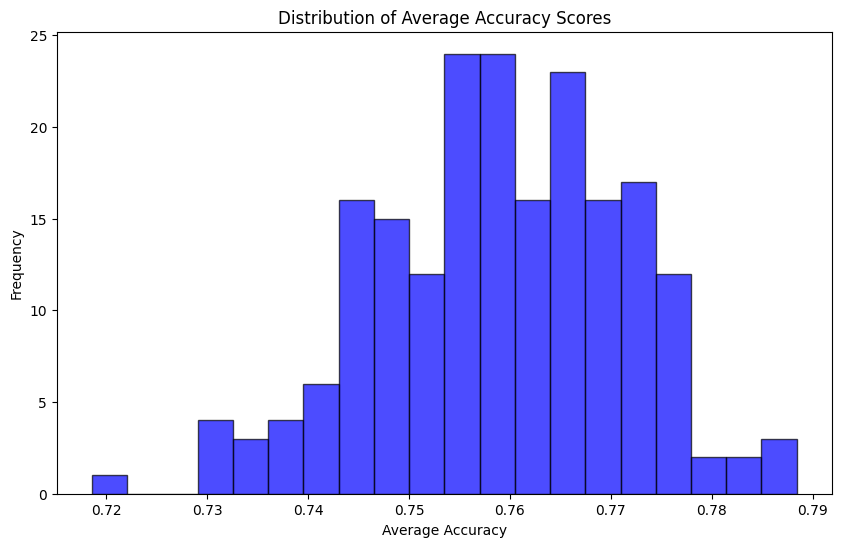

file: beta_data_2_60.csv Average Average Accuracy: 0.7593511784511784
Average Accuracy: 0.76996632996633
Average Accuracy: 0.7956902356902357
Average Accuracy: 0.7661952861952862
Average Accuracy: 0.7736700336700337
Average Accuracy: 0.780875420875421
Average Accuracy: 0.7773737373737374
Average Accuracy: 0.780942760942761
Average Accuracy: 0.7811447811447811
Average Accuracy: 0.7847138047138047
Average Accuracy: 0.7772390572390572
Average Accuracy: 0.7591245791245791
Average Accuracy: 0.7770370370370371
Average Accuracy: 0.7847138047138047
Average Accuracy: 0.781010101010101
Average Accuracy: 0.7775757575757576
Average Accuracy: 0.7846464646464646
Average Accuracy: 0.780942760942761
Average Accuracy: 0.7885521885521886
Average Accuracy: 0.7696969696969697
Average Accuracy: 0.7700336700336701
Average Accuracy: 0.7846464646464646
Average Accuracy: 0.7736700336700337
Average Accuracy: 0.7920538720538721
Average Accuracy: 0.781010101010101
Average Accuracy: 0.7774410774410774
Average Accu

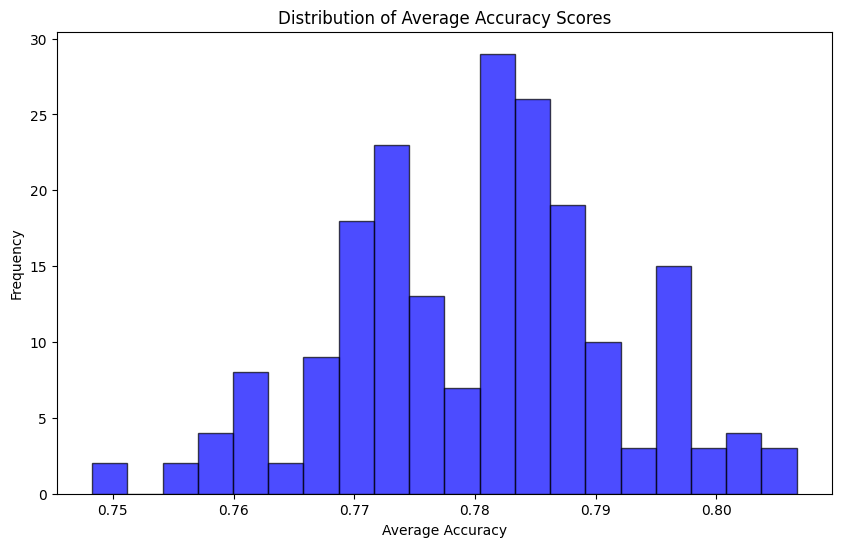

file: beta_data_7_42.csv Average Average Accuracy: 0.7803020202020201
Average Accuracy: 0.7664646464646465
Average Accuracy: 0.7554882154882157
Average Accuracy: 0.7482154882154882
Average Accuracy: 0.7664646464646465
Average Accuracy: 0.7553535353535354
Average Accuracy: 0.7513804713804715
Average Accuracy: 0.7589225589225589
Average Accuracy: 0.751986531986532
Average Accuracy: 0.7554208754208755
Average Accuracy: 0.7553535353535354
Average Accuracy: 0.7772390572390572
Average Accuracy: 0.7627609427609429
Average Accuracy: 0.7810774410774411
Average Accuracy: 0.7734680134680135
Average Accuracy: 0.7592592592592593
Average Accuracy: 0.7736700336700337
Average Accuracy: 0.76989898989899
Average Accuracy: 0.759057239057239
Average Accuracy: 0.7518518518518519
Average Accuracy: 0.7848484848484849
Average Accuracy: 0.7884175084175085
Average Accuracy: 0.7555555555555555
Average Accuracy: 0.7553535353535354
Average Accuracy: 0.7703703703703704
Average Accuracy: 0.7771043771043772
Average A

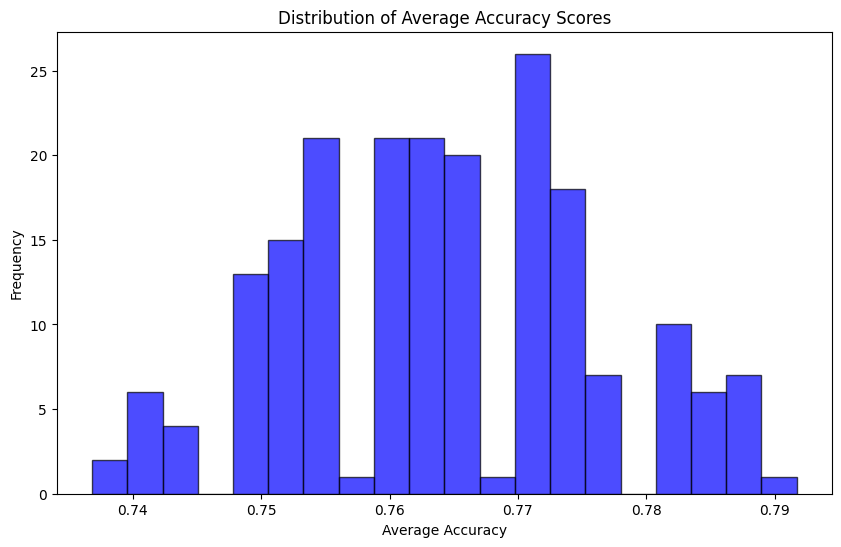

file: beta_data_7_120.csv Average Average Accuracy: 0.7639976430976431
Average Accuracy: 0.7585858585858587
Average Accuracy: 0.7626936026936028
Average Accuracy: 0.743973063973064
Average Accuracy: 0.7372390572390571
Average Accuracy: 0.7628282828282829
Average Accuracy: 0.751919191919192
Average Accuracy: 0.7736700336700337
Average Accuracy: 0.7516498316498317
Average Accuracy: 0.7628282828282829
Average Accuracy: 0.7665993265993267
Average Accuracy: 0.7660606060606061
Average Accuracy: 0.7703030303030304
Average Accuracy: 0.76996632996633
Average Accuracy: 0.7847138047138047
Average Accuracy: 0.7846464646464647
Average Accuracy: 0.7484175084175085
Average Accuracy: 0.758989898989899
Average Accuracy: 0.7703030303030303
Average Accuracy: 0.7845117845117844
Average Accuracy: 0.7735353535353535
Average Accuracy: 0.7773737373737374
Average Accuracy: 0.7666666666666667
Average Accuracy: 0.7773737373737374
Average Accuracy: 0.7770370370370371
Average Accuracy: 0.7700336700336701
Average A

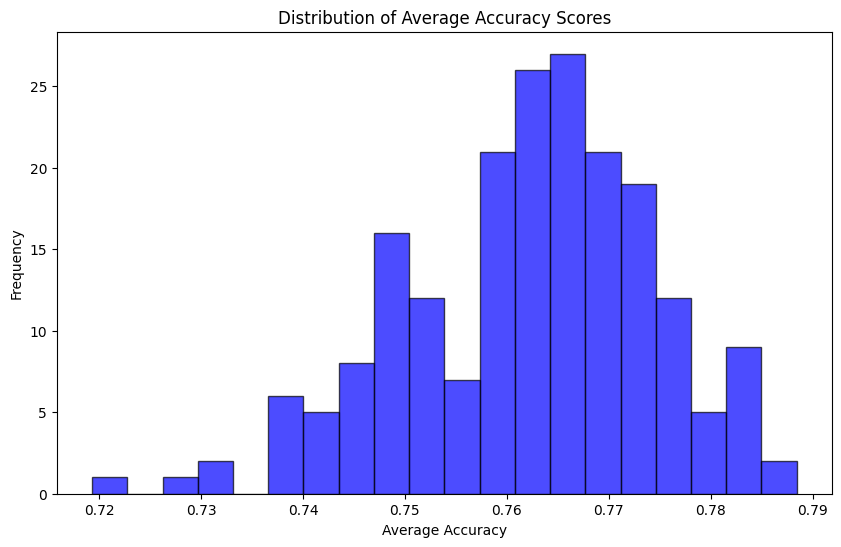

file: beta_data_2_120.csv Average Average Accuracy: 0.7623835016835018
Average Accuracy: 0.7847811447811448
Average Accuracy: 0.8028956228956229
Average Accuracy: 0.7955555555555555
Average Accuracy: 0.7957575757575758
Average Accuracy: 0.7773737373737374
Average Accuracy: 0.7771043771043771
Average Accuracy: 0.780875420875421
Average Accuracy: 0.7884175084175085
Average Accuracy: 0.7773063973063973
Average Accuracy: 0.7628282828282827
Average Accuracy: 0.7703703703703704
Average Accuracy: 0.7881481481481482
Average Accuracy: 0.7958922558922559
Average Accuracy: 0.8030976430976432
Average Accuracy: 0.8030976430976431
Average Accuracy: 0.799057239057239
Average Accuracy: 0.7917171717171717
Average Accuracy: 0.7919191919191919
Average Accuracy: 0.8065319865319864
Average Accuracy: 0.7993265993265994
Average Accuracy: 0.7740740740740741
Average Accuracy: 0.7847811447811448
Average Accuracy: 0.7956228956228956
Average Accuracy: 0.7771717171717173
Average Accuracy: 0.7958249158249158
Averag

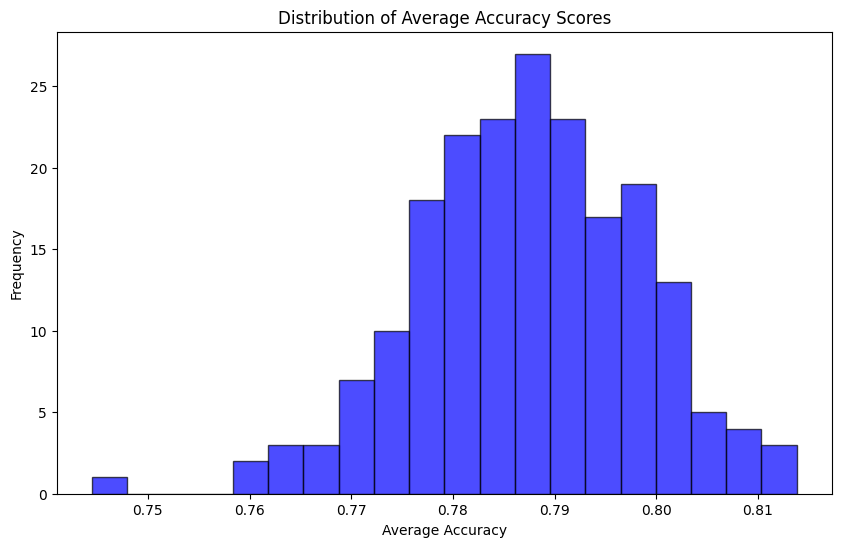

file: beta_data_2_42.csv Average Average Accuracy: 0.7878084175084175
Average Accuracy: 0.7773063973063973
Average Accuracy: 0.7775084175084175
Average Accuracy: 0.7812121212121211
Average Accuracy: 0.7591245791245791
Average Accuracy: 0.7736700336700336
Average Accuracy: 0.7773737373737373
Average Accuracy: 0.7664646464646465
Average Accuracy: 0.7517845117845118
Average Accuracy: 0.7591245791245791
Average Accuracy: 0.7626936026936028
Average Accuracy: 0.7700336700336701
Average Accuracy: 0.7845791245791245
Average Accuracy: 0.7810774410774411
Average Accuracy: 0.7630303030303032
Average Accuracy: 0.7737373737373737
Average Accuracy: 0.7921885521885523
Average Accuracy: 0.7775757575757576
Average Accuracy: 0.7776430976430977
Average Accuracy: 0.7517845117845118
Average Accuracy: 0.7771717171717173
Average Accuracy: 0.7697643097643098
Average Accuracy: 0.7407407407407407
Average Accuracy: 0.7702356902356903
Average Accuracy: 0.7810774410774411
Average Accuracy: 0.7808080808080808
Avera

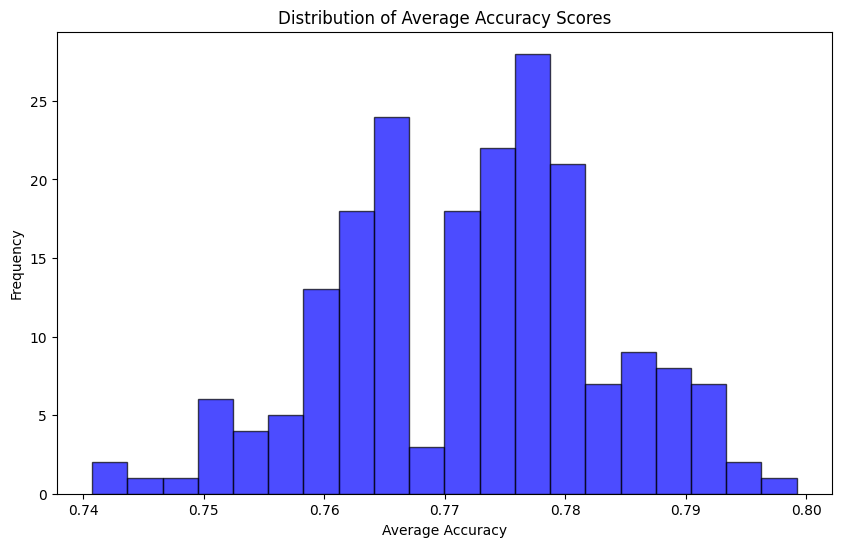

file: beta_data_7_60.csv Average Average Accuracy: 0.7721616161616162


In [20]:
# iterate for all the data files in the folder 'beta_dates
for file in os.listdir('beta_dates'):
    new_avg_accuracy_scores = []

    if file == 'true_labels.csv':
        continue

    for i in range(200):
        # Number of splits for K-Fold Cross-Validation
        n_splits = 5
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

        X, y = load_data_cv(data_address='beta_dates/' + file)

        famd = FAMD(n_components=8)
        famd.fit(X)
        X = famd.transform(X)

        # create a pipeline with the best parameters
        pipe = Pipeline([
            ('xgb', XGBClassifier(objective='multi:softmax')),
        ])

        # Perform K-Fold Cross-Validation

        # set the parameters to the mean values
        pipe.set_params(**means)

        accuracy_scores = []
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Fit the pipeline to the training data
            pipe.fit(X_train, y_train)

            # Make predictions on the test set
            predictions = pipe.predict(X_test)

            # Evaluate the model
            # print(classification_report(y_test, predictions))
            # print("Accuracy:", accuracy_score(y_test, predictions))
            accuracy_scores.append(accuracy_score(y_test, predictions))

        print("Average Accuracy:", np.mean(accuracy_scores))
        new_avg_accuracy_scores.append(np.mean(accuracy_scores))
    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(new_avg_accuracy_scores, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Average Accuracy Scores')
    plt.xlabel('Average Accuracy')
    plt.ylabel('Frequency')
    plt.show()
    print("file:", file, "Average Average Accuracy:", np.mean(new_avg_accuracy_scores))

In [32]:
# Number of splits for K-Fold Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

X, y = load_data_cv('beta_dates/beta_data_2_42.csv', 'beta_dates/true_labels.csv')

famd = FAMD(n_components=8)
famd.fit(X)
X = famd.transform(X)

# create a pipeline with the best parameters
pipe = Pipeline([
    ('rf', RandomForestClassifier()),
])

# Perform K-Fold Cross-Validation

accuracy_scores = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the pipeline to the training data
    pipe.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = pipe.predict(X_test)

    # Evaluate the model
    print(classification_report(y_test, predictions))
    print("Accuracy:", accuracy_score(y_test, predictions))
    accuracy_scores.append(accuracy_score(y_test, predictions))

print("Average Accuracy:", np.mean(accuracy_scores))


              precision    recall  f1-score   support

         0.0       1.00      0.57      0.73         7
         1.0       0.86      0.97      0.91        38
         2.0       0.75      0.60      0.67        10

    accuracy                           0.85        55
   macro avg       0.87      0.72      0.77        55
weighted avg       0.86      0.85      0.84        55

Accuracy: 0.8545454545454545
              precision    recall  f1-score   support

         0.0       0.75      0.50      0.60         6
         1.0       0.77      0.89      0.83        38
         2.0       0.57      0.36      0.44        11

    accuracy                           0.75        55
   macro avg       0.70      0.59      0.62        55
weighted avg       0.73      0.75      0.73        55

Accuracy: 0.7454545454545455
              precision    recall  f1-score   support

         0.0       0.33      0.17      0.22         6
         1.0       0.79      0.89      0.84        38
         2.0     

In [44]:
# Number of splits for K-Fold Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

X, y = load_data_cv()

famd = FAMD(n_components=8)
famd.fit(X)
X = famd.transform(X)

# create a pipeline with the best parameters
pipe = Pipeline([
    ('logreg', LogisticRegression(max_iter=1000, multi_class='multinomial')),
])
# Perform K-Fold Cross-Validation

accuracy_scores = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the pipeline to the training data
    pipe.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = pipe.predict(X_test)

    # Evaluate the model
    print(classification_report(y_test, predictions))
    print("Accuracy:", accuracy_score(y_test, predictions))
    accuracy_scores.append(accuracy_score(y_test, predictions))

print("Average Accuracy:", np.mean(accuracy_scores))


              precision    recall  f1-score   support

         0.0       1.00      0.29      0.44         7
         1.0       0.78      0.92      0.84        38
         2.0       0.62      0.50      0.56        10

    accuracy                           0.76        55
   macro avg       0.80      0.57      0.61        55
weighted avg       0.78      0.76      0.74        55

Accuracy: 0.7636363636363637
              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67         6
         1.0       0.80      0.87      0.84        38
         2.0       0.62      0.45      0.53        11

    accuracy                           0.76        55
   macro avg       0.70      0.66      0.68        55
weighted avg       0.75      0.76      0.76        55

Accuracy: 0.7636363636363637
              precision    recall  f1-score   support

         0.0       0.60      0.50      0.55         6
         1.0       0.79      0.82      0.81        38
         2.0     

In [69]:
# Number of splits for K-Fold Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

X, y = load_data_cv()

famd = FAMD(n_components=8)
famd.fit(X)
X = famd.transform(X)
# imputer = SimpleImputer(strategy='mean')
# Perform K-Fold Cross-Validation

pipe = Pipeline([
        # ('imputer', imputer),  # Impute any NaNs that might be produced by FAMD
        ('qda', QuadraticDiscriminantAnalysis()),
    ])
accuracy_scores = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the pipeline to the training data
    pipe.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = pipe.predict(X_test)

    # Evaluate the model
    print(classification_report(y_test, predictions))
    print("Accuracy:", accuracy_score(y_test, predictions))


              precision    recall  f1-score   support

         0.0       0.50      0.43      0.46         7
         1.0       0.89      0.66      0.76        38
         2.0       0.43      0.90      0.58        10

    accuracy                           0.67        55
   macro avg       0.61      0.66      0.60        55
weighted avg       0.76      0.67      0.69        55

Accuracy: 0.6727272727272727
              precision    recall  f1-score   support

         0.0       0.75      0.50      0.60         6
         1.0       0.82      0.74      0.78        38
         2.0       0.47      0.73      0.57        11

    accuracy                           0.71        55
   macro avg       0.68      0.65      0.65        55
weighted avg       0.74      0.71      0.72        55

Accuracy: 0.7090909090909091
              precision    recall  f1-score   support

         0.0       0.40      0.67      0.50         6
         1.0       0.86      0.47      0.61        38
         2.0     

In [97]:
# Number of splits for K-Fold Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

X, y = load_data_cv()

famd = FAMD(n_components=8)
famd.fit(X)
X = famd.transform(X)
# imputer = SimpleImputer(strategy='mean')
# Perform K-Fold Cross-Validation

pipe = Pipeline([
        # ('imputer', imputer),  # Impute any NaNs that might be produced by FAMD
        ('lda', LinearDiscriminantAnalysis()),
    ])
accuracy_scores = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the pipeline to the training data
    pipe.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = pipe.predict(X_test)

    # Evaluate the model
    print(classification_report(y_test, predictions))
    print("Accuracy:", accuracy_score(y_test, predictions))


              precision    recall  f1-score   support

         0.0       0.62      0.71      0.67         7
         1.0       0.78      0.74      0.76        38
         2.0       0.36      0.40      0.38        10

    accuracy                           0.67        55
   macro avg       0.59      0.62      0.60        55
weighted avg       0.68      0.67      0.68        55

Accuracy: 0.6727272727272727
              precision    recall  f1-score   support

         0.0       0.80      0.67      0.73         6
         1.0       0.84      0.95      0.89        38
         2.0       0.86      0.55      0.67        11

    accuracy                           0.84        55
   macro avg       0.83      0.72      0.76        55
weighted avg       0.84      0.84      0.83        55

Accuracy: 0.8363636363636363
              precision    recall  f1-score   support

         0.0       0.29      0.33      0.31         6
         1.0       0.72      0.74      0.73        38
         2.0     

In [16]:
# X_train, X_test, y_train, y_test = load_data()
# # create a pipeline for XGBoost, FAMD, Random Forests, and Multiclass logistic regression
# pipe = Pipeline([
#         ('svd', FAMD()),
#         ('xgb', XGBClassifier(objective='multi:softmax', random_state=42)),
#         ])

# # create a parameter grid for the pipeline

# param_grid = {
# 'svd__n_components': 5,
#  'xgb__colsample_bytree': 0.8, 
#  'xgb__gamma': 0.5, 
#  'xgb__learning_rate': 0.1,
#    'xgb__max_depth': 3, 
#    'xgb__min_child_weight': 2, 
#    'xgb__n_estimators': 200, 
#    'xgb__reg_alpha': 10, 
#    'xgb__reg_lambda': 20, 
#    'xgb__subsample': 0.7}


# pipe.fit(X_train, y_train).score(X_test, y_test)

# pipe.set_params(**param_grid).fit(X_train, y_train).score(X_test, y_test)

# # Predictions
# predictions = pipe.predict(X_test)

# # Evaluation
# print(classification_report(y_test, predictions))

# Random Forest Bayesian Search

In [17]:
X_train, X_test, y_train, y_test = load_data()

# Create a pipeline for Random Forests
pipe = Pipeline([
    ('famd', FAMD()),
    ('rf', RandomForestClassifier()),
])

# Define the evaluation function
def rf_evaluate(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    params = {
        'rf__n_estimators': int(n_estimators),
        'rf__max_depth': int(max_depth),
        'rf__min_samples_split': int(min_samples_split),
        'rf__min_samples_leaf': int(min_samples_leaf),
        'rf__max_features': max_features,
    }
    pipe.set_params(**params)
    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    return accuracy_score(y_test, predictions)

# Bayesian Optimization
optimizer = BayesianOptimization(
    f=rf_evaluate,
    pbounds={
        'n_estimators': (50, 300),
        'max_depth': (3, 5),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 4),
        'max_features': (0.1,1)
    },
    random_state=42
)

optimizer.maximize(init_points=5, n_iter=200)

# After optimization, retrieve and adjust best parameters for pipeline
xgb_best_params = optimizer.max['params']
best_params_for_pipeline = {'rf__' + key: int(value) if key in ['max_depth', 'n_estimators', 'min_samples_split', 'min_samples_leaf'] else value for key, value in xgb_best_params.items()}

# Set the best parameters in the pipeline
pipe.set_params(**best_params_for_pipeline)
pipe.fit(X_train, y_train)

# Predictions and Evaluation
predictions = pipe.predict(X_test)
print(classification_report(y_test, predictions))

# Print best parameters and performance
print("Best Parameters for Pipeline:", best_params_for_pipeline)
print("Best Performance:", optimizer.max['target'])



|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 0.7826    | 3.749     | 0.9556    | 3.196     | 6.789     | 89.0      |
| 2         | 0.7826    | 3.312     | 0.1523    | 3.599     | 6.809     | 227.0     |
| 3         | 0.7681    | 3.041     | 0.9729    | 3.497     | 3.699     | 95.46     |
| 4         | 0.7826    | 3.367     | 0.3738    | 2.574     | 5.456     | 122.8     |
| 5         | 0.7826    | 4.224     | 0.2255    | 1.876     | 4.931     | 164.0     |
| 6         | 0.7826    | 3.152     | 0.2818    | 2.973     | 5.548     | 122.7     |
| 7         | 0.7681    | 3.483     | 0.6423    | 2.23      | 8.99      | 83.2      |
| 8         | 0.7826    | 4.564     | 0.1       | 1.74      | 6.177     | 118.2     |
| 9         | 0.7826    | 4.074     | 0.7616    | 1.916     | 9.875     | 121.5     |
| 10        | 0.7826    | 4.563     | 0.2015    | 3.94

In [86]:
# Number of splits for K-Fold Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

X, y = load_data_cv('beta_dates/beta_data_2_42.csv', 'beta_dates/true_labels.csv')

famd = FAMD(n_components=8)
famd.fit(X)
X = famd.transform(X)

# create a pipeline with the best parameters
pipe = Pipeline([
    ('rf', RandomForestClassifier()),
])

def rf_evaluate(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    params = {
        'rf__n_estimators': int(n_estimators),
        'rf__max_depth': int(max_depth),
        'rf__min_samples_split': int(min_samples_split),
        'rf__min_samples_leaf': int(min_samples_leaf),
        'rf__max_features': max_features,
    }
    pipe.set_params(**params)
    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    return accuracy_score(y_test, predictions)

# Perform K-Fold Cross-Validation

rf_accuracy_scores = []
rf_params = []
for train_index, test_index in skf.split(X, y):

    # Bayesian Optimization
    optimizer = BayesianOptimization(
        f=rf_evaluate,
        pbounds={
            'n_estimators': (50, 300),
            'max_depth': (3, 5),
            'min_samples_split': (2, 10),
            'min_samples_leaf': (1, 4),
            'max_features': (0.1,1)
        },
    )
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    optimizer.maximize(init_points=5, n_iter=200)

    # After optimization, retrieve and adjust best parameters for pipeline
    rf_best_params = optimizer.max['params']
    rf_best_params_for_pipeline = {'rf__' + key: int(value) if key in ['max_depth', 'n_estimators', 'min_samples_split', 'min_samples_leaf'] else value for key, value in rf_best_params.items()}

    # Set the best parameters in the pipeline
    pipe.set_params(**rf_best_params_for_pipeline)
    pipe.fit(X_train, y_train)

    # Predictions and Evaluation
    predictions = pipe.predict(X_test)
    print(classification_report(y_test, predictions))

    # Print best parameters and performance
    print("Best Parameters for Pipeline:", rf_best_params_for_pipeline)
    print("Best Performance:", optimizer.max['target'])

    rf_accuracy_scores.append(optimizer.max['target'])
    rf_params.append(rf_best_params_for_pipeline)

print("Average Accuracy:", np.mean(accuracy_scores))


|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 0.7455    | 3.874     | 0.6468    | 1.142     | 6.551     | 209.6     |
| 2         | 0.7455    | 3.788     | 0.7339    | 1.465     | 5.587     | 279.9     |
| 3         | 0.7636    | 4.463     | 0.2515    | 1.347     | 7.99      | 257.5     |
| 4         | 0.7636    | 3.937     | 0.4532    | 1.418     | 7.689     | 245.8     |
| 5         | 0.7455    | 4.729     | 0.9953    | 3.838     | 2.137     | 95.24     |
| 6         | 0.7455    | 3.805     | 0.1252    | 1.7       | 6.636     | 245.9     |
| 7         | 0.7455    | 4.994     | 0.645     | 1.42      | 3.854     | 60.67     |
| 8         | 0.7455    | 4.794     | 0.8226    | 3.662     | 4.246     | 131.5     |
| 9         | 0.7636    | 3.423     | 0.3824    | 2.144     | 4.063     | 143.7     |
| 10        | 0.7455    | 4.37      | 0.1336    | 3.77

/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


| 1         | 0.8       | 4.861     | 0.8193    | 3.648     | 2.804     | 133.1     |
| 2         | 0.8182    | 3.295     | 0.7608    | 2.085     | 9.067     | 269.7     |
| 3         | 0.7273    | 3.428     | 0.1626    | 3.018     | 6.042     | 295.0     |
| 4         | 0.8182    | 3.818     | 0.7771    | 2.311     | 3.317     | 252.1     |
| 5         | 0.8545    | 3.144     | 0.6931    | 1.656     | 9.28      | 137.3     |
| 6         | 0.8364    | 3.263     | 0.797     | 3.639     | 4.044     | 69.21     |
| 7         | 0.8       | 4.789     | 0.3145    | 3.628     | 7.535     | 210.8     |
| 8         | 0.8182    | 4.086     | 0.4043    | 3.651     | 3.785     | 241.3     |
| 9         | 0.8364    | 3.993     | 0.4215    | 2.515     | 8.019     | 118.2     |
| 10        | 0.7818    | 4.226     | 0.642     | 2.271     | 3.266     | 252.2     |
| 11        | 0.8364    | 3.126     | 0.6641    | 3.38      | 8.265     | 262.0     |
| 12        | 0.7455    | 3.355     | 0.2267    | 3.00

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [87]:
rf_params

[{'rf__max_depth': 3,
  'rf__max_features': 0.578216089699401,
  'rf__min_samples_leaf': 2,
  'rf__min_samples_split': 8,
  'rf__n_estimators': 274},
 {'rf__max_depth': 3,
  'rf__max_features': 0.6930522933094876,
  'rf__min_samples_leaf': 1,
  'rf__min_samples_split': 9,
  'rf__n_estimators': 137},
 {'rf__max_depth': 3,
  'rf__max_features': 0.8009493839785741,
  'rf__min_samples_leaf': 2,
  'rf__min_samples_split': 6,
  'rf__n_estimators': 135},
 {'rf__max_depth': 4,
  'rf__max_features': 0.7286695862611113,
  'rf__min_samples_leaf': 3,
  'rf__min_samples_split': 7,
  'rf__n_estimators': 121},
 {'rf__max_depth': 3,
  'rf__max_features': 0.5190280038316526,
  'rf__min_samples_leaf': 2,
  'rf__min_samples_split': 9,
  'rf__n_estimators': 50}]

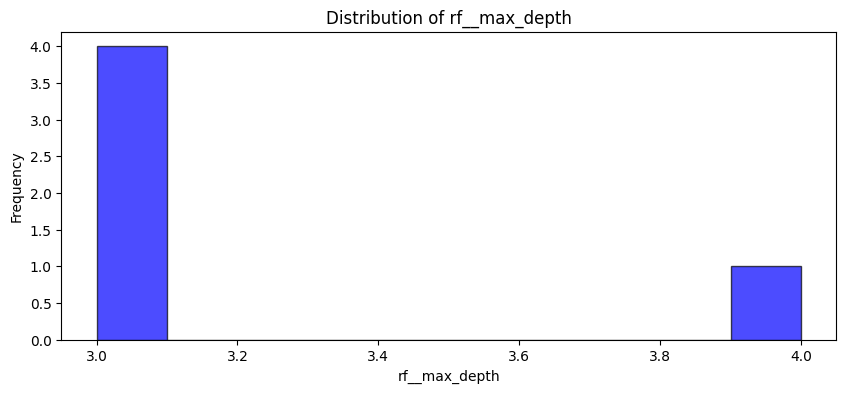

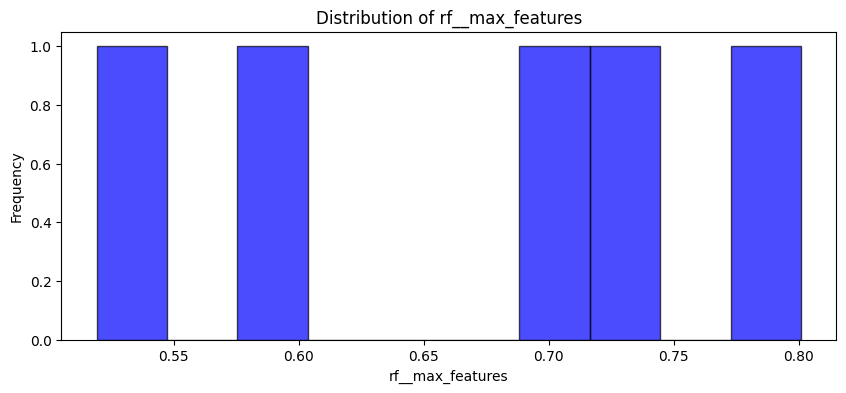

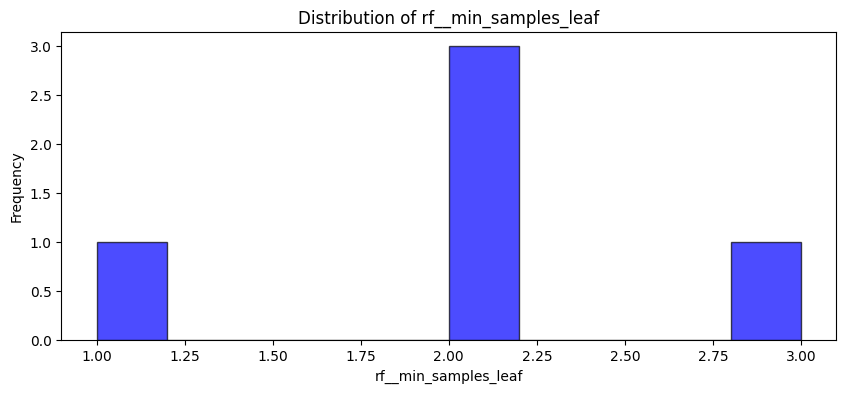

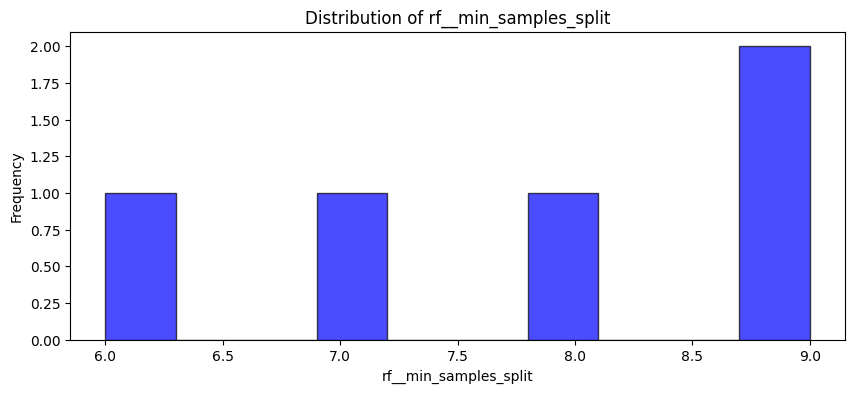

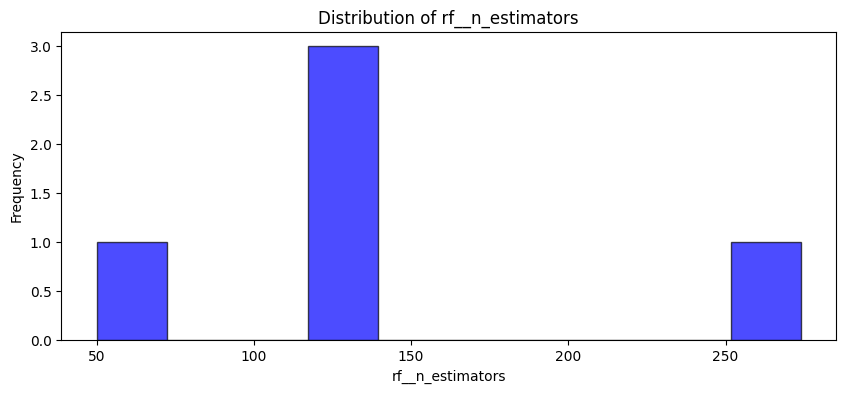

Mean values of parameters: {'rf__max_depth': 3, 'rf__max_features': 0.6639830714160453, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 8, 'rf__n_estimators': 143}


In [88]:
# create visualization of the best parameters, a visualization
param_values = {
    'rf__max_depth': [],
    'rf__max_features': [],
    'rf__min_samples_leaf': [],
    'rf__min_samples_split': [],
    'rf__n_estimators': [],
}

# Populate the lists
for param_set in rf_params:
    for param, value in param_set.items():
        param_values[param].append(value)

# Create histograms
for param, values in param_values.items():
    plt.figure(figsize=(10, 4))
    plt.hist(values, bins=10, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Distribution of {param}')
    plt.xlabel(param)
    plt.ylabel('Frequency')
    plt.show()
    
# Initialize a dictionary to store the sum of each parameter
sums = {
    'rf__max_depth': 0,
    'rf__max_features': 0,
    'rf__min_samples_leaf': 0,
    'rf__min_samples_split': 0,
    'rf__n_estimators': 0,
}

# Sum up the values for each parameter
for param_set in rf_params:
    for param, value in param_set.items():
        sums[param] += value

# Calculate the mean for each parameter
means = {param: sum_val / len(params) for param, sum_val in sums.items()}

# round integer features
means['rf__max_depth'] = int(round(means['rf__max_depth']))
means['rf__n_estimators'] = int(round(means['rf__n_estimators']))
means['rf__min_samples_leaf'] = int(round(means['rf__min_samples_leaf']))
means['rf__min_samples_split'] = int(round(means['rf__min_samples_split']))

print("Mean values of parameters:", means)

In [ ]:
{'rf__max_depth': 3, 'rf__max_features': 0.6639830714160453, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 8, 'rf__n_estimators': 143}

Average Accuracy: 0.7812121212121212
Average Accuracy: 0.781010101010101
Average Accuracy: 0.7697643097643098
Average Accuracy: 0.7773063973063973
Average Accuracy: 0.7697643097643098
Average Accuracy: 0.7774410774410774
Average Accuracy: 0.7663299663299663
Average Accuracy: 0.7738720538720539
Average Accuracy: 0.7664646464646465
Average Accuracy: 0.7849158249158249
Average Accuracy: 0.76996632996633
Average Accuracy: 0.7773063973063973
Average Accuracy: 0.7552188552188552
Average Accuracy: 0.7773737373737374
Average Accuracy: 0.7882828282828283
Average Accuracy: 0.7554882154882157
Average Accuracy: 0.7775084175084175
Average Accuracy: 0.781010101010101
Average Accuracy: 0.7701683501683502
Average Accuracy: 0.7591245791245791


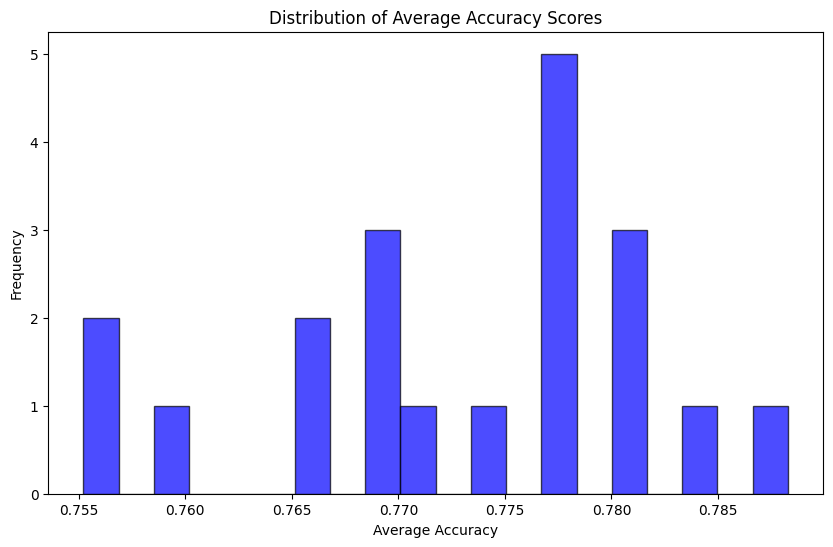

file: beta_data_2_60.csv Average Average Accuracy: 0.7729764309764311 params: {'rf__max_depth': 3, 'rf__max_features': 0.578216089699401, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 8, 'rf__n_estimators': 274}
Average Accuracy: 0.7957575757575758
Average Accuracy: 0.7917171717171717
Average Accuracy: 0.7736700336700337
Average Accuracy: 0.7700336700336701
Average Accuracy: 0.7956228956228956
Average Accuracy: 0.7884175084175085
Average Accuracy: 0.7848484848484849
Average Accuracy: 0.780942760942761
Average Accuracy: 0.7846464646464646
Average Accuracy: 0.7957575757575758
Average Accuracy: 0.7919191919191919
Average Accuracy: 0.7808080808080808
Average Accuracy: 0.7955555555555556
Average Accuracy: 0.7958249158249158
Average Accuracy: 0.7810774410774411
Average Accuracy: 0.7991245791245791
Average Accuracy: 0.7773063973063973
Average Accuracy: 0.7848484848484849
Average Accuracy: 0.7920538720538721
Average Accuracy: 0.7883501683501684


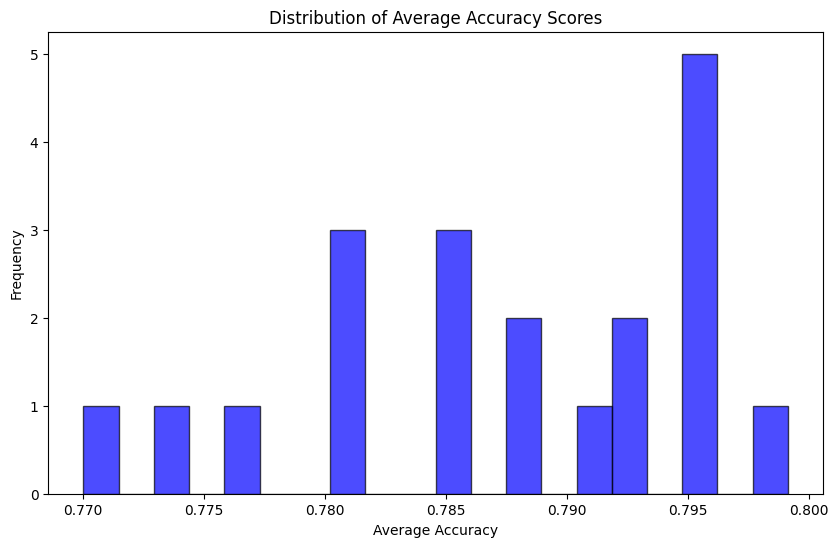

file: beta_data_7_42.csv Average Average Accuracy: 0.7874141414141415 params: {'rf__max_depth': 3, 'rf__max_features': 0.578216089699401, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 8, 'rf__n_estimators': 274}
Average Accuracy: 0.7626936026936028
Average Accuracy: 0.780942760942761
Average Accuracy: 0.7773063973063975
Average Accuracy: 0.7846464646464646
Average Accuracy: 0.76989898989899
Average Accuracy: 0.7847811447811448
Average Accuracy: 0.7810774410774411
Average Accuracy: 0.7738047138047138
Average Accuracy: 0.76996632996633
Average Accuracy: 0.7919191919191919
Average Accuracy: 0.7738720538720539
Average Accuracy: 0.788080808080808
Average Accuracy: 0.7698316498316499
Average Accuracy: 0.781010101010101
Average Accuracy: 0.7697643097643098
Average Accuracy: 0.7628282828282829
Average Accuracy: 0.7697643097643099
Average Accuracy: 0.7702356902356903
Average Accuracy: 0.7882828282828284
Average Accuracy: 0.7700336700336701


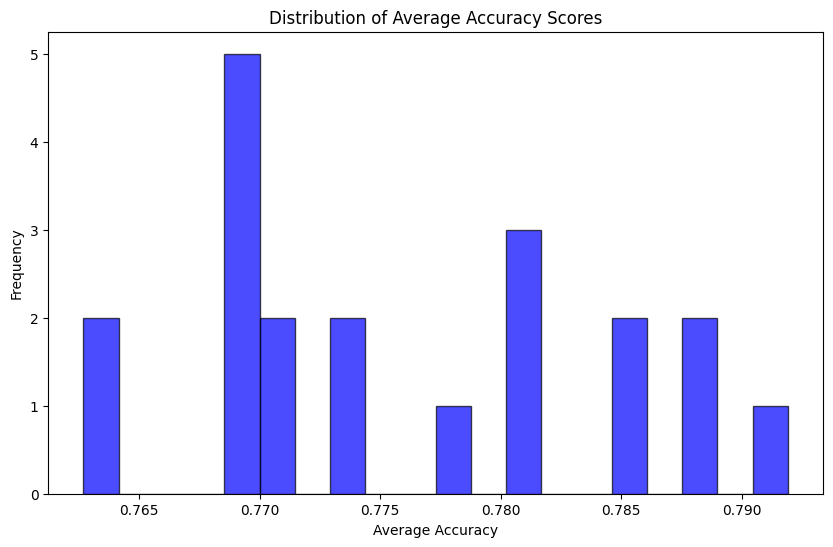

file: beta_data_7_120.csv Average Average Accuracy: 0.7760370370370371 params: {'rf__max_depth': 3, 'rf__max_features': 0.578216089699401, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 8, 'rf__n_estimators': 274}
Average Accuracy: 0.7847811447811448
Average Accuracy: 0.7736700336700337
Average Accuracy: 0.7882154882154883
Average Accuracy: 0.7920538720538721
Average Accuracy: 0.7812794612794614
Average Accuracy: 0.7591245791245791
Average Accuracy: 0.7736700336700337
Average Accuracy: 0.780942760942761
Average Accuracy: 0.781010101010101
Average Accuracy: 0.780875420875421
Average Accuracy: 0.7845791245791247
Average Accuracy: 0.7774410774410775
Average Accuracy: 0.7737373737373737
Average Accuracy: 0.7663973063973065
Average Accuracy: 0.780942760942761
Average Accuracy: 0.781010101010101
Average Accuracy: 0.7883501683501684
Average Accuracy: 0.7775757575757576
Average Accuracy: 0.7663973063973065
Average Accuracy: 0.7734680134680134


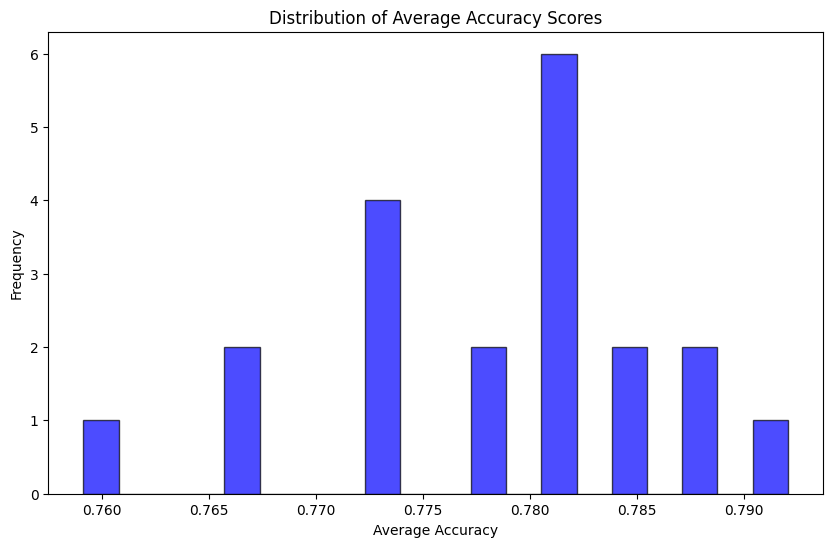

file: beta_data_2_120.csv Average Average Accuracy: 0.7782760942760943 params: {'rf__max_depth': 3, 'rf__max_features': 0.578216089699401, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 8, 'rf__n_estimators': 274}
Average Accuracy: 0.780942760942761
Average Accuracy: 0.7738047138047138
Average Accuracy: 0.7921212121212122
Average Accuracy: 0.8026262626262627
Average Accuracy: 0.8030303030303031
Average Accuracy: 0.7884848484848486
Average Accuracy: 0.7993939393939395
Average Accuracy: 0.7882154882154883
Average Accuracy: 0.7991245791245791
Average Accuracy: 0.7918518518518518
Average Accuracy: 0.7809427609427608
Average Accuracy: 0.781010101010101
Average Accuracy: 0.7991919191919192
Average Accuracy: 0.7993939393939394
Average Accuracy: 0.7992592592592593
Average Accuracy: 0.7956228956228957
Average Accuracy: 0.7884175084175085
Average Accuracy: 0.7882828282828284
Average Accuracy: 0.7955555555555556
Average Accuracy: 0.7956228956228957


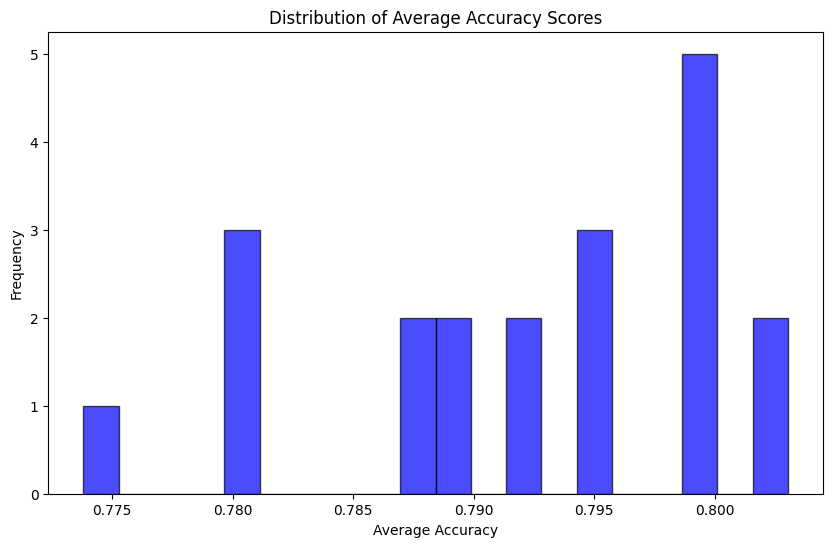

file: beta_data_2_42.csv Average Average Accuracy: 0.792144781144781 params: {'rf__max_depth': 3, 'rf__max_features': 0.578216089699401, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 8, 'rf__n_estimators': 274}
Average Accuracy: 0.7772390572390572
Average Accuracy: 0.7775084175084176
Average Accuracy: 0.7845117845117844
Average Accuracy: 0.7738047138047138
Average Accuracy: 0.7884175084175085
Average Accuracy: 0.7846464646464647
Average Accuracy: 0.7847138047138047
Average Accuracy: 0.7664646464646465
Average Accuracy: 0.781077441077441
Average Accuracy: 0.780875420875421
Average Accuracy: 0.7957575757575758
Average Accuracy: 0.762962962962963
Average Accuracy: 0.7846464646464646
Average Accuracy: 0.7845117845117846
Average Accuracy: 0.7772390572390572
Average Accuracy: 0.791986531986532
Average Accuracy: 0.7882154882154883
Average Accuracy: 0.7921212121212121
Average Accuracy: 0.7884848484848486
Average Accuracy: 0.784983164983165


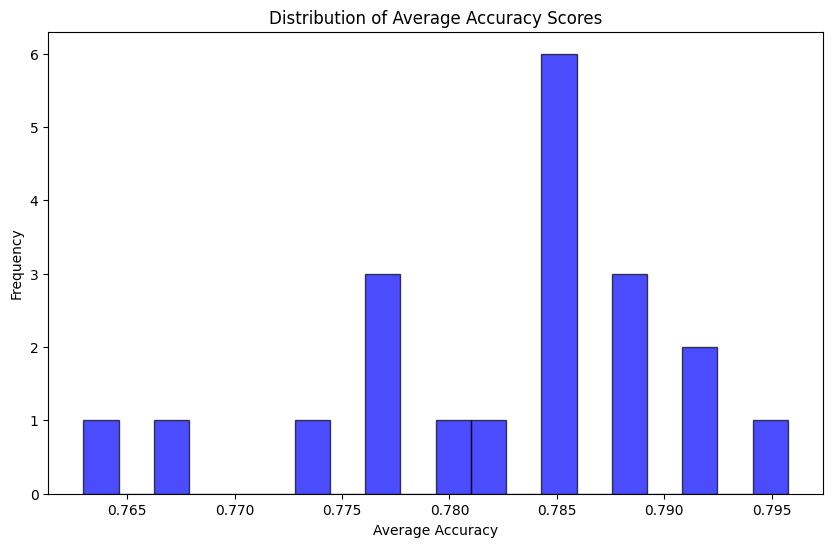

file: beta_data_7_60.csv Average Average Accuracy: 0.7825084175084176 params: {'rf__max_depth': 3, 'rf__max_features': 0.578216089699401, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 8, 'rf__n_estimators': 274}
Average Accuracy: 0.7736026936026936
Average Accuracy: 0.7662626262626263
Average Accuracy: 0.7663299663299663
Average Accuracy: 0.7626936026936028
Average Accuracy: 0.7519191919191919
Average Accuracy: 0.7626936026936028
Average Accuracy: 0.7735353535353535
Average Accuracy: 0.7703703703703704
Average Accuracy: 0.7773063973063973
Average Accuracy: 0.7738047138047139
Average Accuracy: 0.7810101010101009
Average Accuracy: 0.7664646464646465
Average Accuracy: 0.7883501683501684
Average Accuracy: 0.7884175084175086
Average Accuracy: 0.7591245791245791
Average Accuracy: 0.780942760942761
Average Accuracy: 0.7591245791245791
Average Accuracy: 0.7665319865319866
Average Accuracy: 0.7591919191919192
Average Accuracy: 0.7665993265993266


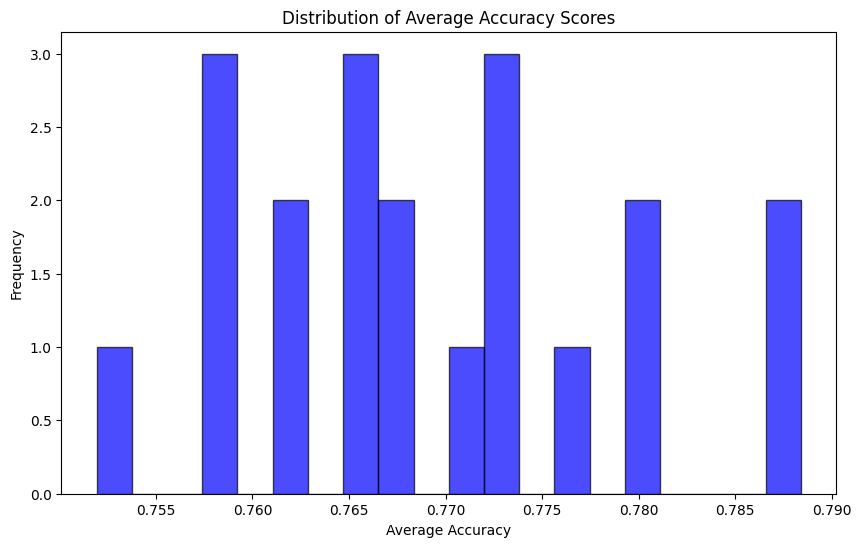

file: beta_data_2_60.csv Average Average Accuracy: 0.7697138047138047 params: {'rf__max_depth': 3, 'rf__max_features': 0.6930522933094876, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 9, 'rf__n_estimators': 137}
Average Accuracy: 0.7812121212121212
Average Accuracy: 0.7773063973063973
Average Accuracy: 0.7920538720538721
Average Accuracy: 0.7846464646464646
Average Accuracy: 0.7774410774410774
Average Accuracy: 0.7884848484848486
Average Accuracy: 0.7812794612794614
Average Accuracy: 0.7919191919191919
Average Accuracy: 0.7663299663299664
Average Accuracy: 0.7665319865319865
Average Accuracy: 0.7844444444444445
Average Accuracy: 0.7956228956228956
Average Accuracy: 0.7881481481481482
Average Accuracy: 0.791986531986532
Average Accuracy: 0.7845791245791245
Average Accuracy: 0.7738720538720539
Average Accuracy: 0.7960269360269361
Average Accuracy: 0.7847811447811448
Average Accuracy: 0.7702356902356902
Average Accuracy: 0.7663973063973064


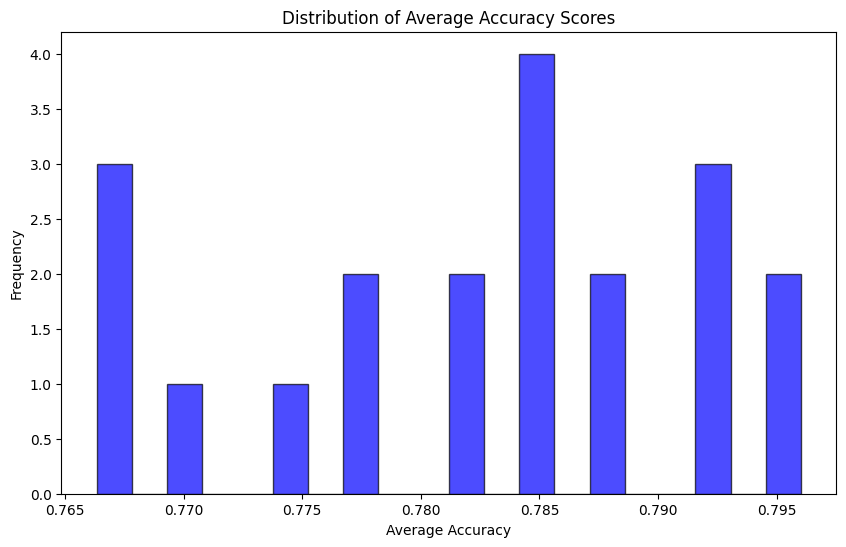

file: beta_data_7_42.csv Average Average Accuracy: 0.7821649831649832 params: {'rf__max_depth': 3, 'rf__max_features': 0.6930522933094876, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 9, 'rf__n_estimators': 137}
Average Accuracy: 0.7553535353535354
Average Accuracy: 0.7882154882154883
Average Accuracy: 0.7773737373737374
Average Accuracy: 0.7703030303030304
Average Accuracy: 0.7700336700336701
Average Accuracy: 0.781010101010101
Average Accuracy: 0.7738047138047138
Average Accuracy: 0.7807407407407407
Average Accuracy: 0.7917845117845118
Average Accuracy: 0.7846464646464646
Average Accuracy: 0.7738047138047139
Average Accuracy: 0.7702356902356903
Average Accuracy: 0.7884175084175085
Average Accuracy: 0.7956228956228957
Average Accuracy: 0.7774410774410774
Average Accuracy: 0.7663299663299664
Average Accuracy: 0.7591245791245791
Average Accuracy: 0.7737373737373737
Average Accuracy: 0.7664646464646465
Average Accuracy: 0.7883501683501684


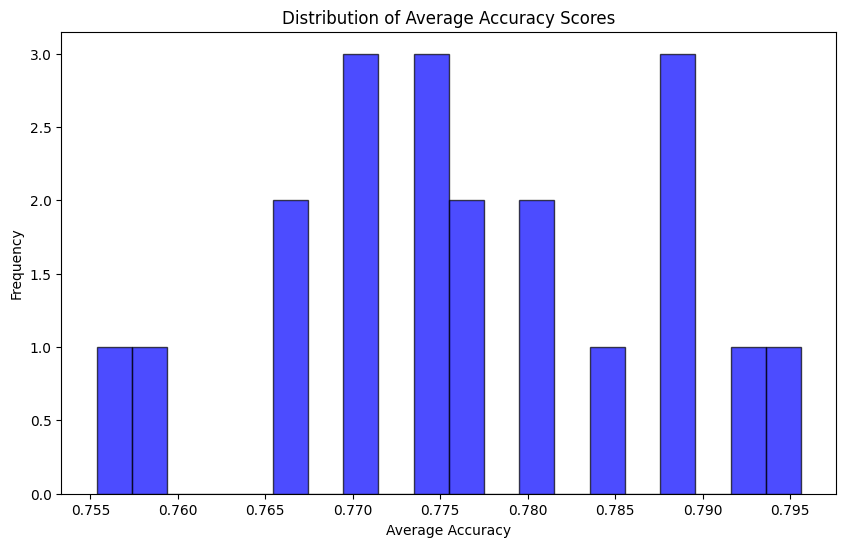

file: beta_data_7_120.csv Average Average Accuracy: 0.7766397306397307 params: {'rf__max_depth': 3, 'rf__max_features': 0.6930522933094876, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 9, 'rf__n_estimators': 137}
Average Accuracy: 0.7666666666666667
Average Accuracy: 0.7663973063973064
Average Accuracy: 0.7627609427609429
Average Accuracy: 0.7734680134680134
Average Accuracy: 0.759057239057239
Average Accuracy: 0.7663973063973064
Average Accuracy: 0.7624242424242424
Average Accuracy: 0.76996632996633
Average Accuracy: 0.7701683501683502
Average Accuracy: 0.7701010101010102
Average Accuracy: 0.7554882154882154
Average Accuracy: 0.7701010101010101
Average Accuracy: 0.762895622895623
Average Accuracy: 0.7845791245791247
Average Accuracy: 0.7808080808080808
Average Accuracy: 0.7738720538720539
Average Accuracy: 0.7847811447811448
Average Accuracy: 0.7738720538720539
Average Accuracy: 0.7773063973063973
Average Accuracy: 0.7773063973063973


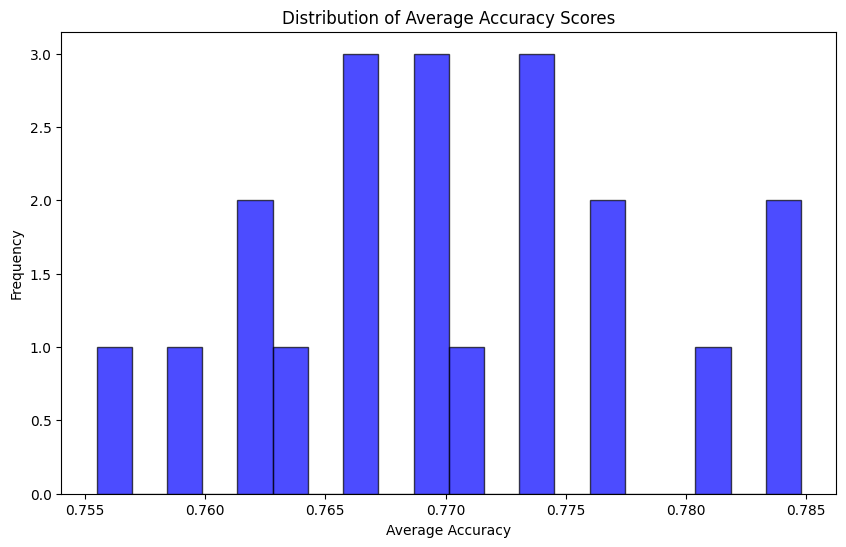

file: beta_data_2_120.csv Average Average Accuracy: 0.7704208754208753 params: {'rf__max_depth': 3, 'rf__max_features': 0.6930522933094876, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 9, 'rf__n_estimators': 137}
Average Accuracy: 0.8028956228956229
Average Accuracy: 0.7954882154882155
Average Accuracy: 0.7956228956228957
Average Accuracy: 0.7847138047138047
Average Accuracy: 0.7957575757575758
Average Accuracy: 0.7992592592592593
Average Accuracy: 0.7882828282828281
Average Accuracy: 0.7918518518518519
Average Accuracy: 0.791986531986532
Average Accuracy: 0.791986531986532
Average Accuracy: 0.7918518518518519
Average Accuracy: 0.7956902356902358
Average Accuracy: 0.7919191919191919
Average Accuracy: 0.802962962962963
Average Accuracy: 0.791986531986532
Average Accuracy: 0.7810774410774411
Average Accuracy: 0.7919191919191919
Average Accuracy: 0.791986531986532
Average Accuracy: 0.7956902356902356
Average Accuracy: 0.7846464646464646


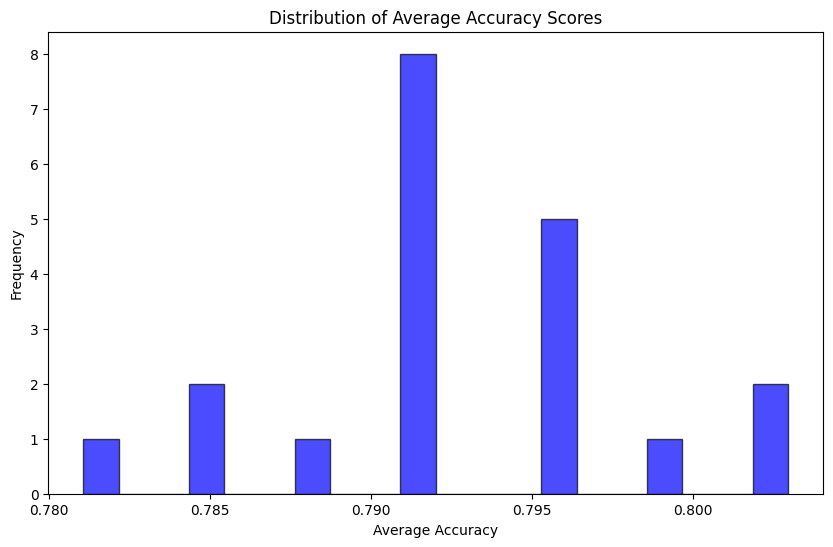

file: beta_data_2_42.csv Average Average Accuracy: 0.7928787878787878 params: {'rf__max_depth': 3, 'rf__max_features': 0.6930522933094876, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 9, 'rf__n_estimators': 137}
Average Accuracy: 0.7884175084175085
Average Accuracy: 0.7917845117845118
Average Accuracy: 0.7845791245791245
Average Accuracy: 0.7773063973063973
Average Accuracy: 0.7773737373737374
Average Accuracy: 0.7775084175084175
Average Accuracy: 0.7882154882154883
Average Accuracy: 0.7810774410774411
Average Accuracy: 0.7845791245791245
Average Accuracy: 0.7919191919191919
Average Accuracy: 0.8066666666666666
Average Accuracy: 0.784915824915825
Average Accuracy: 0.7811447811447811
Average Accuracy: 0.7882828282828283
Average Accuracy: 0.7773063973063973
Average Accuracy: 0.7847811447811448
Average Accuracy: 0.7772390572390572
Average Accuracy: 0.7992592592592593
Average Accuracy: 0.7919191919191919
Average Accuracy: 0.7919191919191919


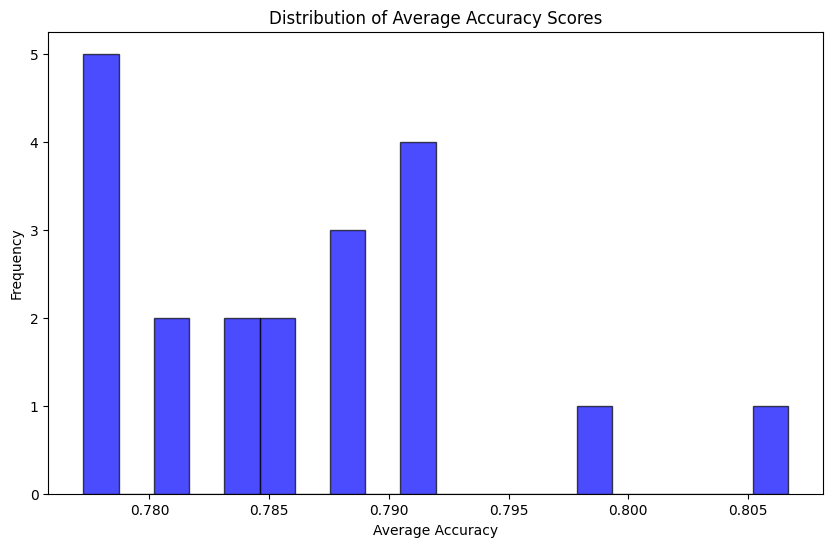

file: beta_data_7_60.csv Average Average Accuracy: 0.7863097643097643 params: {'rf__max_depth': 3, 'rf__max_features': 0.6930522933094876, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 9, 'rf__n_estimators': 137}
Average Accuracy: 0.7737373737373737
Average Accuracy: 0.7772390572390572
Average Accuracy: 0.7701683501683502
Average Accuracy: 0.7737373737373738
Average Accuracy: 0.7846464646464646
Average Accuracy: 0.784915824915825
Average Accuracy: 0.781010101010101
Average Accuracy: 0.7737373737373737
Average Accuracy: 0.7630303030303031
Average Accuracy: 0.7738047138047139
Average Accuracy: 0.7700336700336701
Average Accuracy: 0.7847811447811448
Average Accuracy: 0.7701683501683502
Average Accuracy: 0.7810774410774411
Average Accuracy: 0.7773737373737374
Average Accuracy: 0.7845117845117846
Average Accuracy: 0.759057239057239
Average Accuracy: 0.7812121212121214
Average Accuracy: 0.7810774410774411
Average Accuracy: 0.7737373737373737


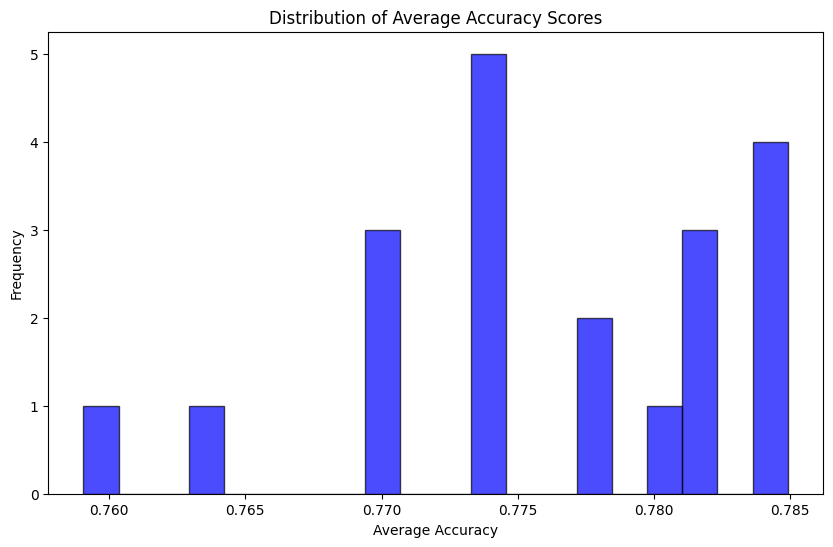

file: beta_data_2_60.csv Average Average Accuracy: 0.775952861952862 params: {'rf__max_depth': 3, 'rf__max_features': 0.8009493839785741, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 6, 'rf__n_estimators': 135}
Average Accuracy: 0.7843097643097644
Average Accuracy: 0.7885521885521886
Average Accuracy: 0.785050505050505
Average Accuracy: 0.7736700336700337
Average Accuracy: 0.7884848484848486
Average Accuracy: 0.7956902356902357
Average Accuracy: 0.7921212121212122
Average Accuracy: 0.7845791245791247
Average Accuracy: 0.7845791245791245
Average Accuracy: 0.7919191919191919
Average Accuracy: 0.7772390572390574
Average Accuracy: 0.7738720538720539
Average Accuracy: 0.7701010101010101
Average Accuracy: 0.7848484848484849
Average Accuracy: 0.7552861952861953
Average Accuracy: 0.781010101010101
Average Accuracy: 0.7626936026936028
Average Accuracy: 0.7664646464646465
Average Accuracy: 0.7918518518518519
Average Accuracy: 0.7775084175084176


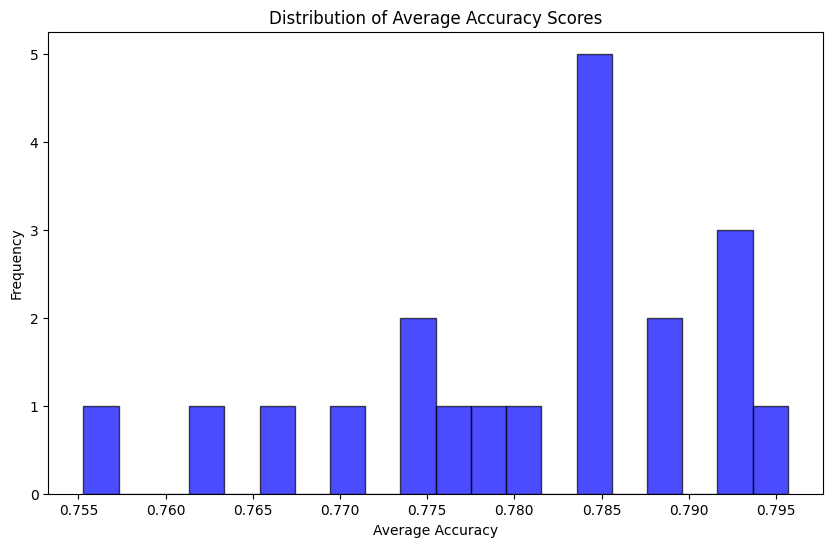

file: beta_data_7_42.csv Average Average Accuracy: 0.7804915824915825 params: {'rf__max_depth': 3, 'rf__max_features': 0.8009493839785741, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 6, 'rf__n_estimators': 135}
Average Accuracy: 0.7775757575757576
Average Accuracy: 0.7627609427609429
Average Accuracy: 0.7701683501683502
Average Accuracy: 0.7556902356902357
Average Accuracy: 0.7702356902356902
Average Accuracy: 0.7701683501683502
Average Accuracy: 0.7740067340067339
Average Accuracy: 0.7664646464646465
Average Accuracy: 0.7736700336700337
Average Accuracy: 0.7663299663299664
Average Accuracy: 0.7810774410774411
Average Accuracy: 0.7884175084175085
Average Accuracy: 0.7665993265993266
Average Accuracy: 0.7591245791245791
Average Accuracy: 0.7701010101010102
Average Accuracy: 0.7701010101010101
Average Accuracy: 0.7517845117845118
Average Accuracy: 0.766060606060606
Average Accuracy: 0.7774410774410774
Average Accuracy: 0.7628282828282827


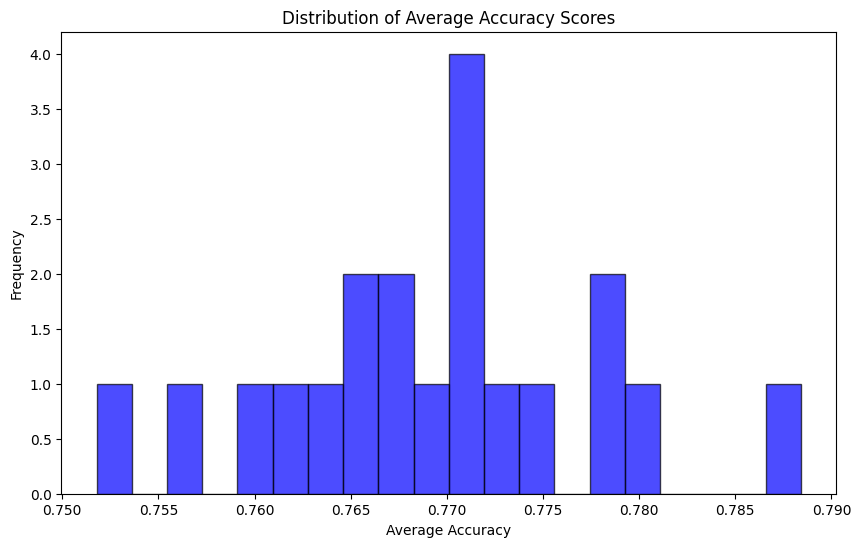

file: beta_data_7_120.csv Average Average Accuracy: 0.7690303030303031 params: {'rf__max_depth': 3, 'rf__max_features': 0.8009493839785741, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 6, 'rf__n_estimators': 135}
Average Accuracy: 0.780942760942761
Average Accuracy: 0.7882828282828283
Average Accuracy: 0.7736700336700336
Average Accuracy: 0.7554882154882154
Average Accuracy: 0.7661279461279461
Average Accuracy: 0.7553535353535354
Average Accuracy: 0.7701010101010101
Average Accuracy: 0.7702356902356902
Average Accuracy: 0.7885521885521886
Average Accuracy: 0.762962962962963
Average Accuracy: 0.7519191919191919
Average Accuracy: 0.7665319865319866
Average Accuracy: 0.7773063973063973
Average Accuracy: 0.7773063973063973
Average Accuracy: 0.76996632996633
Average Accuracy: 0.780875420875421
Average Accuracy: 0.7848484848484849
Average Accuracy: 0.76996632996633
Average Accuracy: 0.7482154882154883
Average Accuracy: 0.7516498316498317


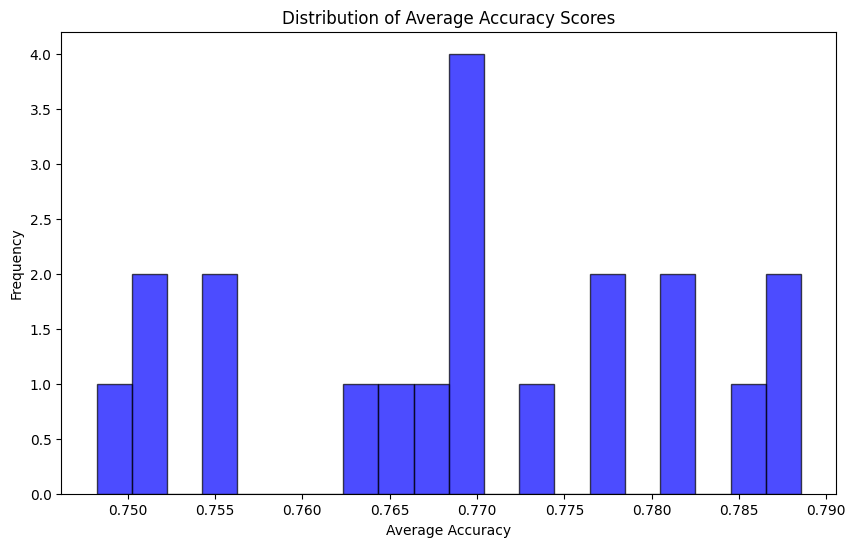

file: beta_data_2_120.csv Average Average Accuracy: 0.7695151515151515 params: {'rf__max_depth': 3, 'rf__max_features': 0.8009493839785741, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 6, 'rf__n_estimators': 135}
Average Accuracy: 0.7991919191919191
Average Accuracy: 0.7882828282828284
Average Accuracy: 0.8100336700336701
Average Accuracy: 0.8026936026936026
Average Accuracy: 0.7626262626262627
Average Accuracy: 0.7773063973063973
Average Accuracy: 0.7880808080808082
Average Accuracy: 0.7737373737373737
Average Accuracy: 0.7883501683501684
Average Accuracy: 0.8068013468013469
Average Accuracy: 0.7810101010101009
Average Accuracy: 0.7627609427609429
Average Accuracy: 0.7991245791245791
Average Accuracy: 0.8064646464646466
Average Accuracy: 0.7991245791245791
Average Accuracy: 0.7922558922558923
Average Accuracy: 0.7954882154882155
Average Accuracy: 0.7956228956228956
Average Accuracy: 0.8102356902356902
Average Accuracy: 0.7991919191919192


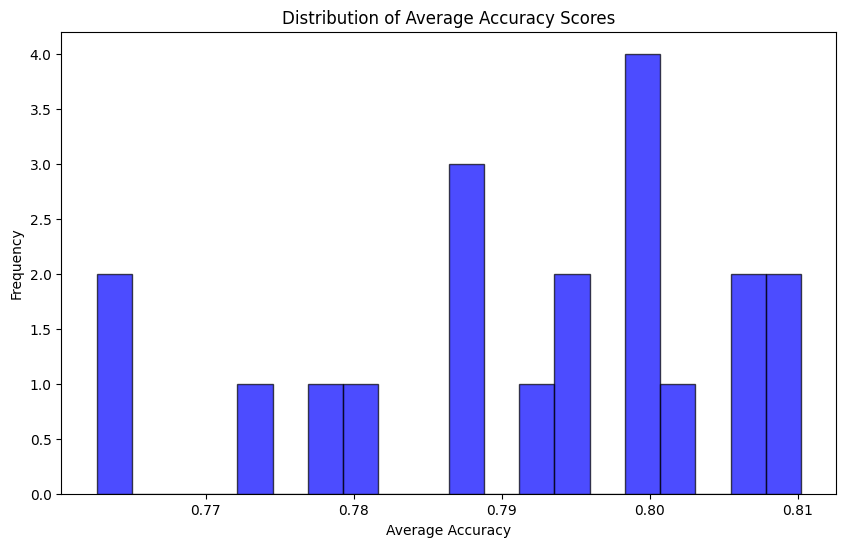

file: beta_data_2_42.csv Average Average Accuracy: 0.7919191919191919 params: {'rf__max_depth': 3, 'rf__max_features': 0.8009493839785741, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 6, 'rf__n_estimators': 135}
Average Accuracy: 0.7881481481481482
Average Accuracy: 0.7956902356902357
Average Accuracy: 0.7882154882154883
Average Accuracy: 0.7847138047138047
Average Accuracy: 0.7845791245791247
Average Accuracy: 0.7880808080808082
Average Accuracy: 0.7774410774410774
Average Accuracy: 0.7956228956228957
Average Accuracy: 0.7736700336700337
Average Accuracy: 0.7882828282828284
Average Accuracy: 0.7845117845117844
Average Accuracy: 0.7883501683501684
Average Accuracy: 0.7771043771043771
Average Accuracy: 0.7521212121212122
Average Accuracy: 0.7884175084175085
Average Accuracy: 0.7700336700336701
Average Accuracy: 0.7846464646464646
Average Accuracy: 0.7956228956228956
Average Accuracy: 0.7701683501683502
Average Accuracy: 0.7956902356902356


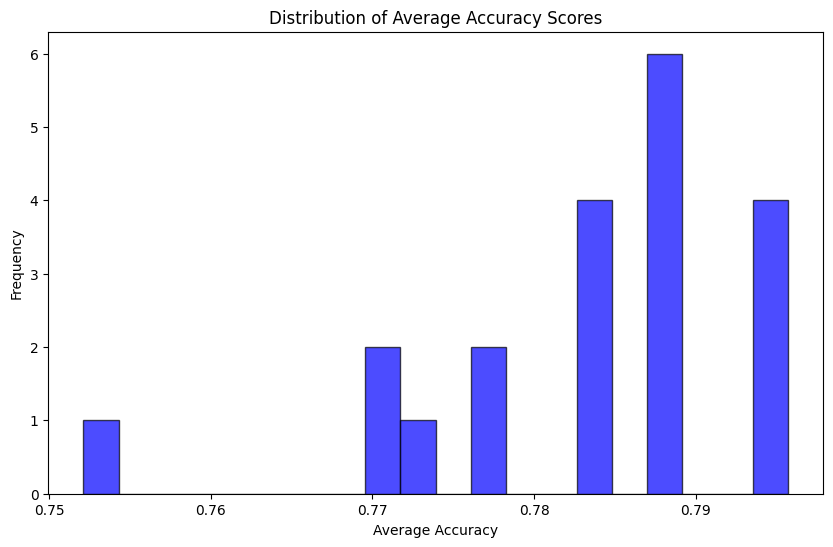

file: beta_data_7_60.csv Average Average Accuracy: 0.7835555555555554 params: {'rf__max_depth': 3, 'rf__max_features': 0.8009493839785741, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 6, 'rf__n_estimators': 135}
Average Accuracy: 0.7810774410774411
Average Accuracy: 0.7772390572390572
Average Accuracy: 0.781010101010101
Average Accuracy: 0.7811447811447811
Average Accuracy: 0.7845791245791245
Average Accuracy: 0.7700336700336701
Average Accuracy: 0.7921212121212122
Average Accuracy: 0.7845117845117846
Average Accuracy: 0.7810774410774411
Average Accuracy: 0.7884175084175084
Average Accuracy: 0.7734006734006734
Average Accuracy: 0.7665993265993266
Average Accuracy: 0.7701010101010101
Average Accuracy: 0.7700336700336701
Average Accuracy: 0.7737373737373737
Average Accuracy: 0.7738047138047138
Average Accuracy: 0.7956228956228957
Average Accuracy: 0.7770370370370371
Average Accuracy: 0.780875420875421
Average Accuracy: 0.781010101010101


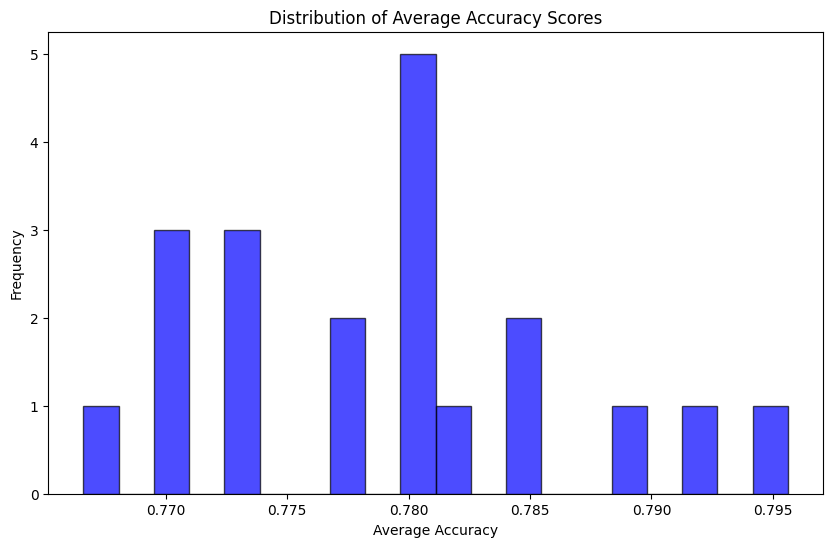

file: beta_data_2_60.csv Average Average Accuracy: 0.7791717171717172 params: {'rf__max_depth': 4, 'rf__max_features': 0.7286695862611113, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 7, 'rf__n_estimators': 121}
Average Accuracy: 0.7884848484848486
Average Accuracy: 0.7811447811447811
Average Accuracy: 0.7846464646464646
Average Accuracy: 0.7737373737373738
Average Accuracy: 0.7843771043771044
Average Accuracy: 0.7919191919191919
Average Accuracy: 0.7883501683501684
Average Accuracy: 0.7918518518518518
Average Accuracy: 0.7774410774410774
Average Accuracy: 0.7665319865319866
Average Accuracy: 0.7845791245791247
Average Accuracy: 0.7918518518518519
Average Accuracy: 0.7920538720538721
Average Accuracy: 0.7883501683501684
Average Accuracy: 0.7772390572390572
Average Accuracy: 0.7883501683501684
Average Accuracy: 0.7954208754208754
Average Accuracy: 0.7918518518518519
Average Accuracy: 0.7845791245791247
Average Accuracy: 0.780875420875421


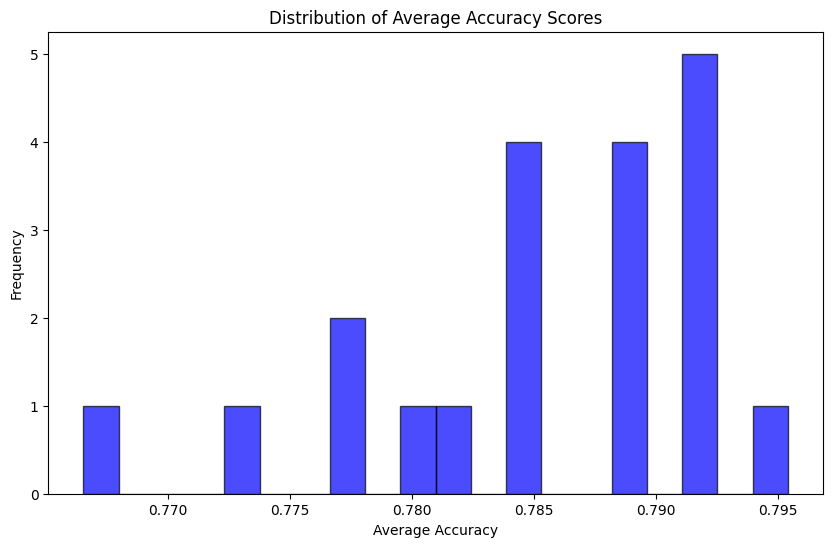

file: beta_data_7_42.csv Average Average Accuracy: 0.7851818181818182 params: {'rf__max_depth': 4, 'rf__max_features': 0.7286695862611113, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 7, 'rf__n_estimators': 121}
Average Accuracy: 0.7735353535353535
Average Accuracy: 0.7738047138047138
Average Accuracy: 0.7736026936026936
Average Accuracy: 0.7517845117845118
Average Accuracy: 0.780942760942761
Average Accuracy: 0.7518518518518519
Average Accuracy: 0.7844444444444445
Average Accuracy: 0.7849158249158249
Average Accuracy: 0.7698989898989899
Average Accuracy: 0.7667340067340067
Average Accuracy: 0.7626936026936025
Average Accuracy: 0.7921885521885523
Average Accuracy: 0.7665319865319865
Average Accuracy: 0.7774410774410774
Average Accuracy: 0.76996632996633
Average Accuracy: 0.7736700336700337
Average Accuracy: 0.7736700336700337
Average Accuracy: 0.762962962962963
Average Accuracy: 0.7662626262626263
Average Accuracy: 0.7667340067340067


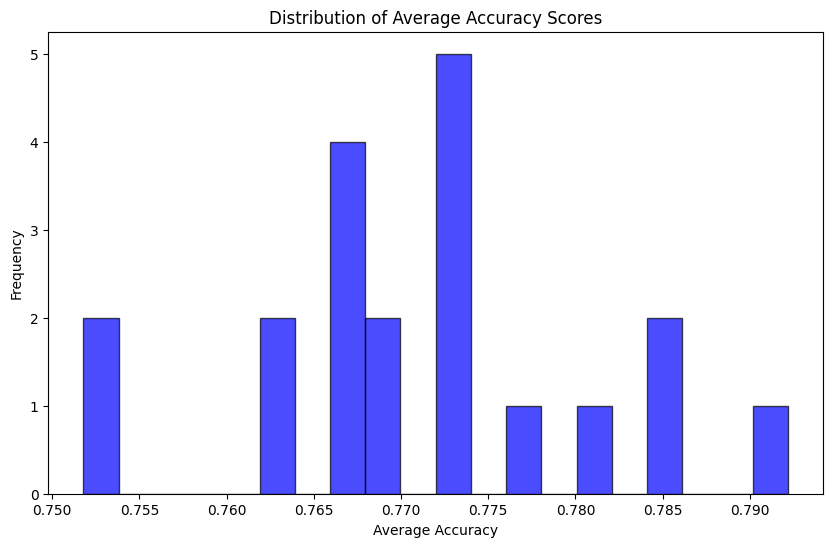

file: beta_data_7_120.csv Average Average Accuracy: 0.7711818181818182 params: {'rf__max_depth': 4, 'rf__max_features': 0.7286695862611113, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 7, 'rf__n_estimators': 121}
Average Accuracy: 0.7848484848484849
Average Accuracy: 0.774074074074074
Average Accuracy: 0.7701683501683502
Average Accuracy: 0.7916498316498316
Average Accuracy: 0.781010101010101
Average Accuracy: 0.7773063973063973
Average Accuracy: 0.7775757575757576
Average Accuracy: 0.7371717171717173
Average Accuracy: 0.7775757575757576
Average Accuracy: 0.7700336700336701
Average Accuracy: 0.7521212121212122
Average Accuracy: 0.7775757575757576
Average Accuracy: 0.7772390572390572
Average Accuracy: 0.7844444444444445
Average Accuracy: 0.7664646464646465
Average Accuracy: 0.7771717171717173
Average Accuracy: 0.7482828282828283
Average Accuracy: 0.7811447811447811
Average Accuracy: 0.7628282828282827
Average Accuracy: 0.759057239057239


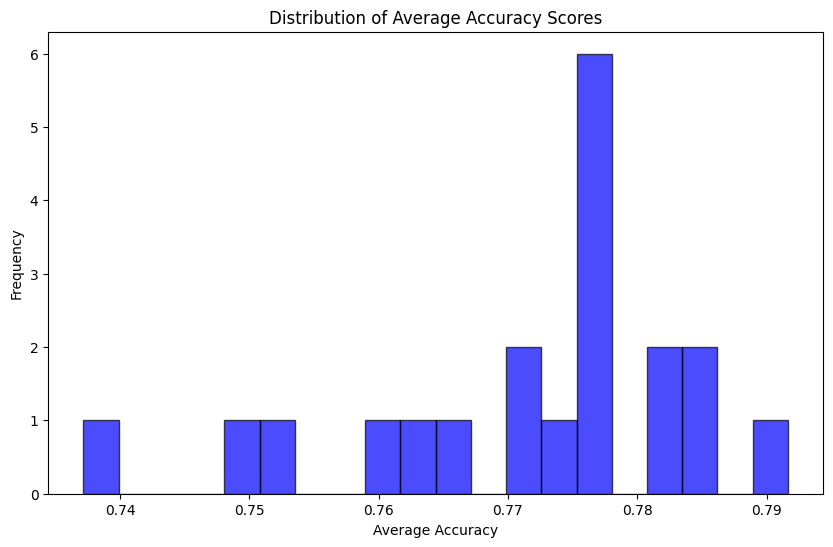

file: beta_data_2_120.csv Average Average Accuracy: 0.7713872053872055 params: {'rf__max_depth': 4, 'rf__max_features': 0.7286695862611113, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 7, 'rf__n_estimators': 121}
Average Accuracy: 0.7920538720538721
Average Accuracy: 0.7845791245791245
Average Accuracy: 0.7883501683501684
Average Accuracy: 0.7883501683501684
Average Accuracy: 0.785050505050505
Average Accuracy: 0.7775084175084175
Average Accuracy: 0.7920538720538721
Average Accuracy: 0.7954208754208754
Average Accuracy: 0.7774410774410774
Average Accuracy: 0.7955555555555556
Average Accuracy: 0.7847138047138047
Average Accuracy: 0.7842424242424243
Average Accuracy: 0.7845791245791247
Average Accuracy: 0.7884848484848486
Average Accuracy: 0.791986531986532
Average Accuracy: 0.7956228956228956
Average Accuracy: 0.7993939393939394
Average Accuracy: 0.7993265993265993
Average Accuracy: 0.7813468013468015
Average Accuracy: 0.7916498316498317


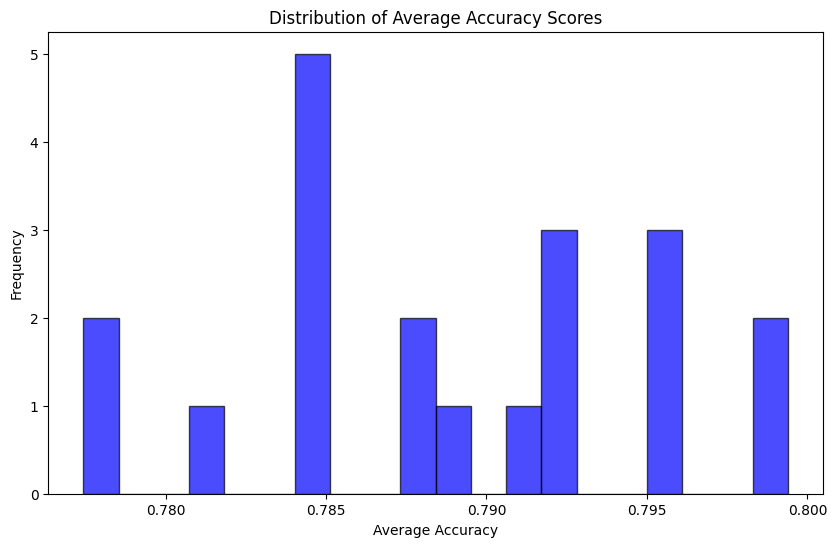

file: beta_data_2_42.csv Average Average Accuracy: 0.7888855218855219 params: {'rf__max_depth': 4, 'rf__max_features': 0.7286695862611113, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 7, 'rf__n_estimators': 121}
Average Accuracy: 0.7992592592592593
Average Accuracy: 0.7991919191919192
Average Accuracy: 0.7954882154882155
Average Accuracy: 0.7991919191919192
Average Accuracy: 0.7846464646464646
Average Accuracy: 0.7774410774410774
Average Accuracy: 0.7847811447811448
Average Accuracy: 0.7845117845117846
Average Accuracy: 0.7739393939393939
Average Accuracy: 0.7700336700336701
Average Accuracy: 0.7847138047138047
Average Accuracy: 0.7882154882154883
Average Accuracy: 0.7880808080808082
Average Accuracy: 0.7774410774410774
Average Accuracy: 0.7807407407407407
Average Accuracy: 0.781077441077441
Average Accuracy: 0.7701683501683502
Average Accuracy: 0.7884175084175085
Average Accuracy: 0.7954208754208754
Average Accuracy: 0.7882828282828284


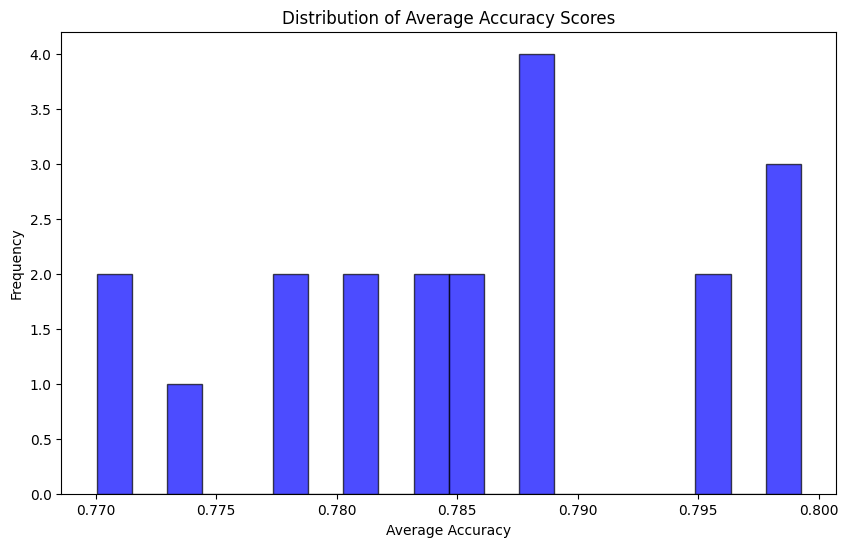

file: beta_data_7_60.csv Average Average Accuracy: 0.7855521885521884 params: {'rf__max_depth': 4, 'rf__max_features': 0.7286695862611113, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 7, 'rf__n_estimators': 121}
Average Accuracy: 0.7812794612794614
Average Accuracy: 0.7812121212121214
Average Accuracy: 0.7700336700336701
Average Accuracy: 0.7624915824915824
Average Accuracy: 0.7772390572390572
Average Accuracy: 0.780942760942761
Average Accuracy: 0.763030303030303
Average Accuracy: 0.7626936026936028
Average Accuracy: 0.7626262626262627
Average Accuracy: 0.7775084175084175
Average Accuracy: 0.76996632996633
Average Accuracy: 0.7991919191919192
Average Accuracy: 0.7736700336700337
Average Accuracy: 0.7701683501683502
Average Accuracy: 0.763030303030303
Average Accuracy: 0.7956228956228956
Average Accuracy: 0.7847138047138047
Average Accuracy: 0.7773063973063973
Average Accuracy: 0.781010101010101
Average Accuracy: 0.7992592592592593


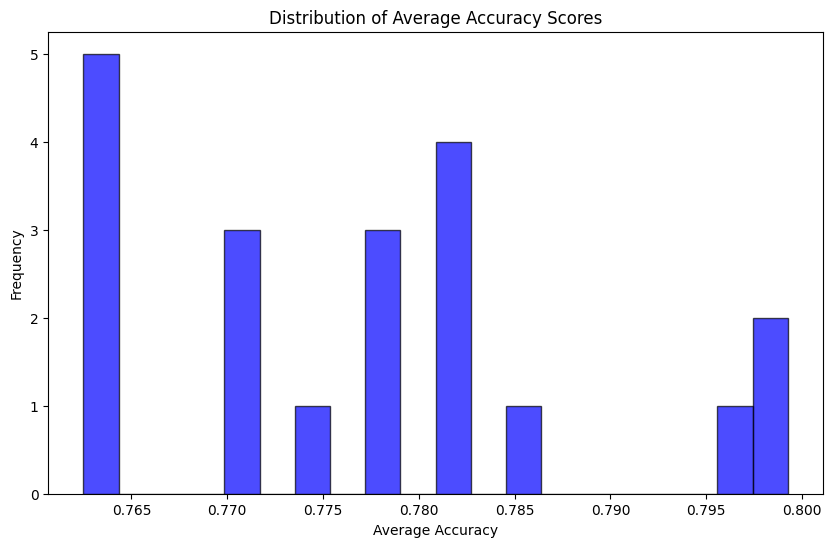

file: beta_data_2_60.csv Average Average Accuracy: 0.7766498316498316 params: {'rf__max_depth': 3, 'rf__max_features': 0.5190280038316526, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 9, 'rf__n_estimators': 50}
Average Accuracy: 0.7734006734006734
Average Accuracy: 0.7736700336700337
Average Accuracy: 0.7883501683501684
Average Accuracy: 0.7882828282828284
Average Accuracy: 0.7626936026936028
Average Accuracy: 0.780942760942761
Average Accuracy: 0.7773063973063973
Average Accuracy: 0.7737373737373737
Average Accuracy: 0.7847138047138047
Average Accuracy: 0.7847138047138047
Average Accuracy: 0.7626936026936028
Average Accuracy: 0.7919865319865319
Average Accuracy: 0.7664646464646465
Average Accuracy: 0.7703030303030303
Average Accuracy: 0.7810774410774411
Average Accuracy: 0.76996632996633
Average Accuracy: 0.7847138047138047
Average Accuracy: 0.791986531986532
Average Accuracy: 0.7922558922558922
Average Accuracy: 0.7920538720538721


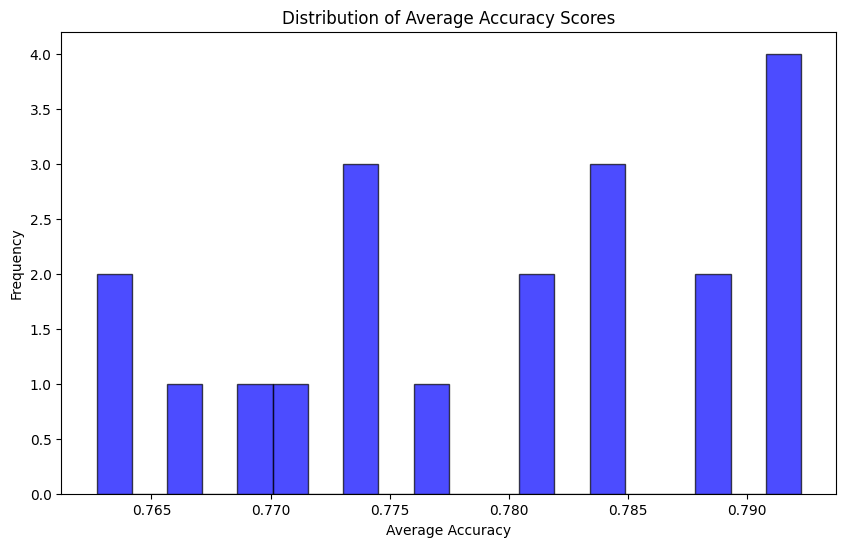

file: beta_data_7_42.csv Average Average Accuracy: 0.7795656565656566 params: {'rf__max_depth': 3, 'rf__max_features': 0.5190280038316526, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 9, 'rf__n_estimators': 50}
Average Accuracy: 0.7665319865319866
Average Accuracy: 0.7880808080808082
Average Accuracy: 0.7701010101010102
Average Accuracy: 0.7628282828282829
Average Accuracy: 0.7701010101010102
Average Accuracy: 0.780942760942761
Average Accuracy: 0.7700336700336701
Average Accuracy: 0.7627609427609429
Average Accuracy: 0.7698316498316499
Average Accuracy: 0.7701010101010102
Average Accuracy: 0.7700336700336701
Average Accuracy: 0.7846464646464646
Average Accuracy: 0.7771717171717172
Average Accuracy: 0.7738047138047139
Average Accuracy: 0.7843771043771045
Average Accuracy: 0.7628282828282827
Average Accuracy: 0.7810774410774411
Average Accuracy: 0.7519191919191919
Average Accuracy: 0.781077441077441
Average Accuracy: 0.7845791245791245


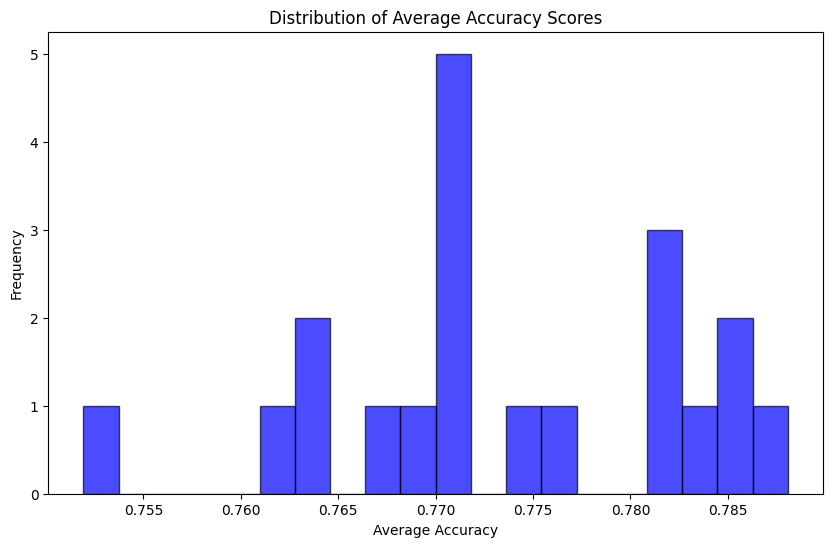

file: beta_data_7_120.csv Average Average Accuracy: 0.7731414141414141 params: {'rf__max_depth': 3, 'rf__max_features': 0.5190280038316526, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 9, 'rf__n_estimators': 50}
Average Accuracy: 0.7591245791245791
Average Accuracy: 0.766060606060606
Average Accuracy: 0.7845791245791245
Average Accuracy: 0.7626262626262627
Average Accuracy: 0.7771717171717172
Average Accuracy: 0.7663299663299663
Average Accuracy: 0.7736700336700336
Average Accuracy: 0.7737373737373737
Average Accuracy: 0.7665319865319866
Average Accuracy: 0.7661952861952862
Average Accuracy: 0.7811447811447811
Average Accuracy: 0.7626262626262627
Average Accuracy: 0.7771043771043772
Average Accuracy: 0.7700336700336701
Average Accuracy: 0.7626262626262628
Average Accuracy: 0.7772390572390572
Average Accuracy: 0.7663299663299664
Average Accuracy: 0.780942760942761
Average Accuracy: 0.7848484848484849
Average Accuracy: 0.7737373737373737


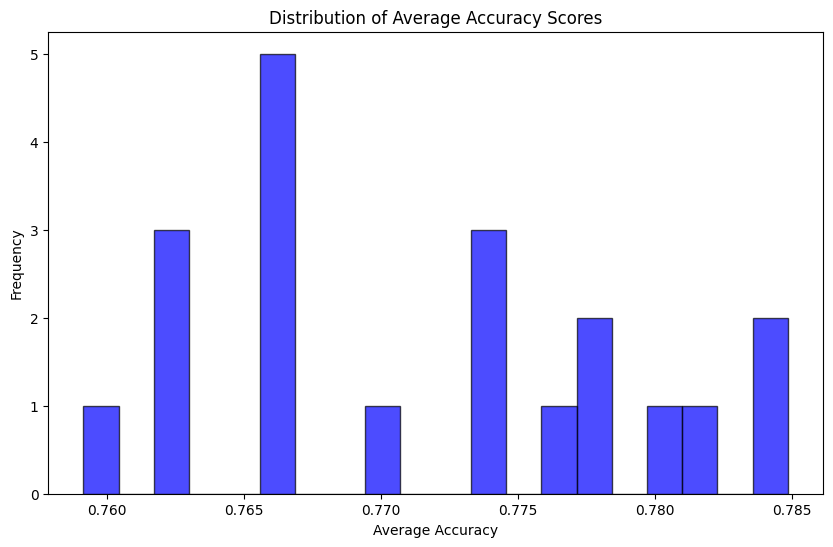

file: beta_data_2_120.csv Average Average Accuracy: 0.7716329966329967 params: {'rf__max_depth': 3, 'rf__max_features': 0.5190280038316526, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 9, 'rf__n_estimators': 50}
Average Accuracy: 0.7885521885521886
Average Accuracy: 0.7774410774410774
Average Accuracy: 0.7845791245791247
Average Accuracy: 0.7883501683501684
Average Accuracy: 0.7920538720538721
Average Accuracy: 0.8030976430976432
Average Accuracy: 0.791986531986532
Average Accuracy: 0.8028956228956229
Average Accuracy: 0.7811447811447811
Average Accuracy: 0.8030976430976432
Average Accuracy: 0.7957575757575758
Average Accuracy: 0.7993265993265994
Average Accuracy: 0.7991919191919191
Average Accuracy: 0.7882828282828283
Average Accuracy: 0.7882154882154883
Average Accuracy: 0.7883501683501684
Average Accuracy: 0.8028956228956229
Average Accuracy: 0.7884175084175085
Average Accuracy: 0.7775757575757576
Average Accuracy: 0.8026936026936028


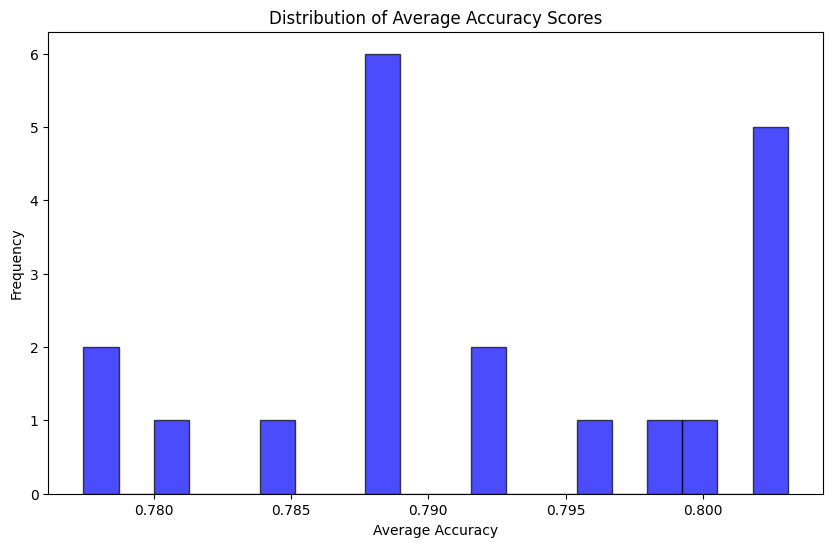

file: beta_data_2_42.csv Average Average Accuracy: 0.7921952861952862 params: {'rf__max_depth': 3, 'rf__max_features': 0.5190280038316526, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 9, 'rf__n_estimators': 50}
Average Accuracy: 0.7993265993265993
Average Accuracy: 0.781010101010101
Average Accuracy: 0.7884175084175085
Average Accuracy: 0.7663299663299663
Average Accuracy: 0.7992592592592593
Average Accuracy: 0.7808080808080808
Average Accuracy: 0.7883501683501684
Average Accuracy: 0.7956228956228957
Average Accuracy: 0.7917171717171717
Average Accuracy: 0.791986531986532
Average Accuracy: 0.7775084175084175
Average Accuracy: 0.7775757575757576
Average Accuracy: 0.7883501683501684
Average Accuracy: 0.7811447811447813
Average Accuracy: 0.7698989898989901
Average Accuracy: 0.7811447811447811
Average Accuracy: 0.7845791245791245
Average Accuracy: 0.7811447811447811
Average Accuracy: 0.7773737373737374
Average Accuracy: 0.7884175084175084


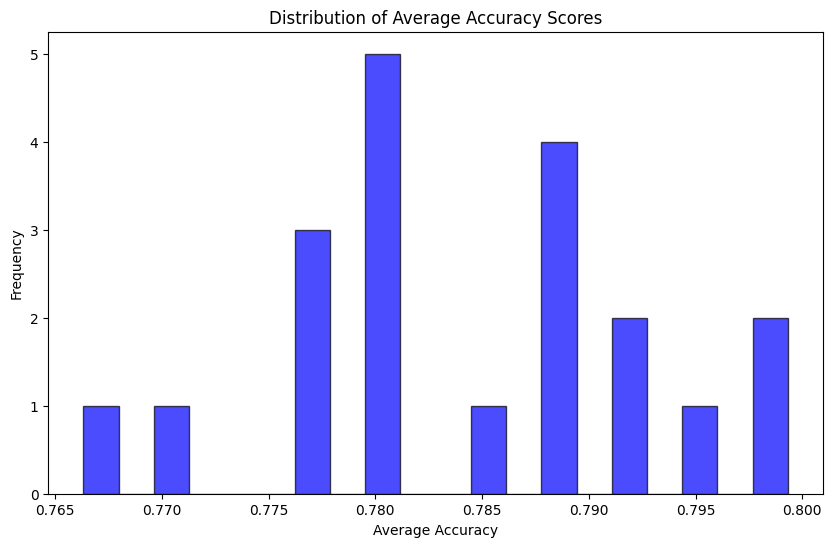

file: beta_data_7_60.csv Average Average Accuracy: 0.7844983164983166 params: {'rf__max_depth': 3, 'rf__max_features': 0.5190280038316526, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 9, 'rf__n_estimators': 50}
Average Accuracy: 0.7662626262626263
Average Accuracy: 0.7700336700336701
Average Accuracy: 0.7773737373737374
Average Accuracy: 0.788013468013468
Average Accuracy: 0.7735353535353535
Average Accuracy: 0.7738047138047137
Average Accuracy: 0.76996632996633
Average Accuracy: 0.7919191919191919
Average Accuracy: 0.7667340067340067
Average Accuracy: 0.76996632996633
Average Accuracy: 0.7736026936026936
Average Accuracy: 0.7588552188552189
Average Accuracy: 0.780942760942761
Average Accuracy: 0.7665993265993267
Average Accuracy: 0.7736026936026936
Average Accuracy: 0.7445117845117846
Average Accuracy: 0.781010101010101
Average Accuracy: 0.7737373737373737
Average Accuracy: 0.7774410774410774
Average Accuracy: 0.7736026936026935


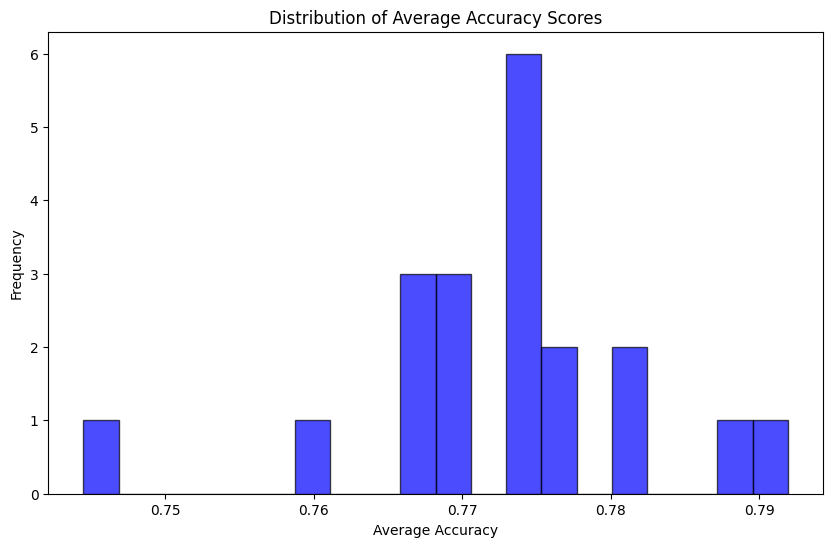

file: beta_data_2_60.csv Average Average Accuracy: 0.7725757575757577 params: {'rf__max_depth': 3, 'rf__max_features': 0.6639830714160453, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 8, 'rf__n_estimators': 143}
Average Accuracy: 0.7847811447811448
Average Accuracy: 0.7884175084175084
Average Accuracy: 0.7775084175084175
Average Accuracy: 0.781010101010101
Average Accuracy: 0.7956902356902358
Average Accuracy: 0.7883501683501684
Average Accuracy: 0.7848484848484849
Average Accuracy: 0.7846464646464647
Average Accuracy: 0.7920538720538721
Average Accuracy: 0.7919191919191919
Average Accuracy: 0.7847811447811448
Average Accuracy: 0.7847138047138047
Average Accuracy: 0.7812794612794614
Average Accuracy: 0.7773737373737374
Average Accuracy: 0.7847138047138047
Average Accuracy: 0.7918518518518519
Average Accuracy: 0.7846464646464646
Average Accuracy: 0.7737373737373737
Average Accuracy: 0.7663299663299663
Average Accuracy: 0.7918518518518519


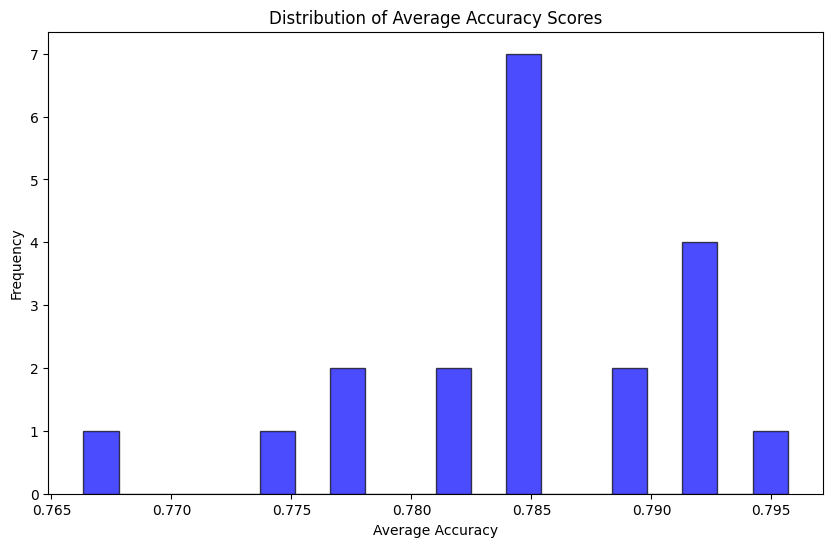

file: beta_data_7_42.csv Average Average Accuracy: 0.7845252525252525 params: {'rf__max_depth': 3, 'rf__max_features': 0.6639830714160453, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 8, 'rf__n_estimators': 143}
Average Accuracy: 0.7773737373737373
Average Accuracy: 0.7736700336700336
Average Accuracy: 0.762962962962963
Average Accuracy: 0.7515824915824917
Average Accuracy: 0.7664646464646465
Average Accuracy: 0.7736700336700337
Average Accuracy: 0.7773737373737374
Average Accuracy: 0.7589225589225589
Average Accuracy: 0.7882828282828284
Average Accuracy: 0.7734680134680134
Average Accuracy: 0.7772390572390572
Average Accuracy: 0.7591919191919192
Average Accuracy: 0.7700336700336701
Average Accuracy: 0.7736026936026936
Average Accuracy: 0.7736026936026936
Average Accuracy: 0.7701010101010102
Average Accuracy: 0.7774410774410774
Average Accuracy: 0.7811447811447811
Average Accuracy: 0.7847811447811448
Average Accuracy: 0.7882828282828284


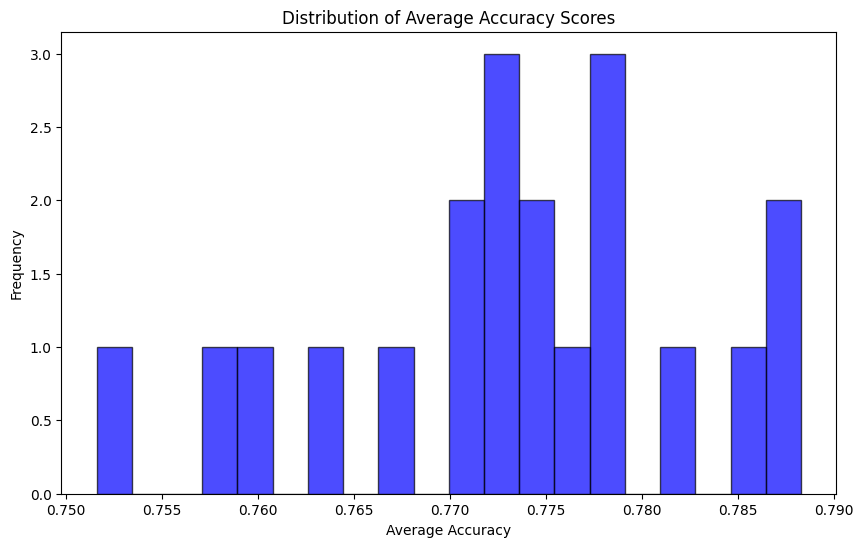

file: beta_data_7_120.csv Average Average Accuracy: 0.7729595959595958 params: {'rf__max_depth': 3, 'rf__max_features': 0.6639830714160453, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 8, 'rf__n_estimators': 143}
Average Accuracy: 0.7772390572390572
Average Accuracy: 0.7811447811447811
Average Accuracy: 0.76996632996633
Average Accuracy: 0.7740067340067341
Average Accuracy: 0.7735353535353535
Average Accuracy: 0.7736700336700337
Average Accuracy: 0.781010101010101
Average Accuracy: 0.7552188552188552
Average Accuracy: 0.7663973063973065
Average Accuracy: 0.7775757575757576
Average Accuracy: 0.7736700336700337
Average Accuracy: 0.7663299663299664
Average Accuracy: 0.7845791245791247
Average Accuracy: 0.7846464646464646
Average Accuracy: 0.7771717171717172
Average Accuracy: 0.7882828282828283
Average Accuracy: 0.781010101010101
Average Accuracy: 0.7918518518518519
Average Accuracy: 0.7702356902356903
Average Accuracy: 0.7736026936026935


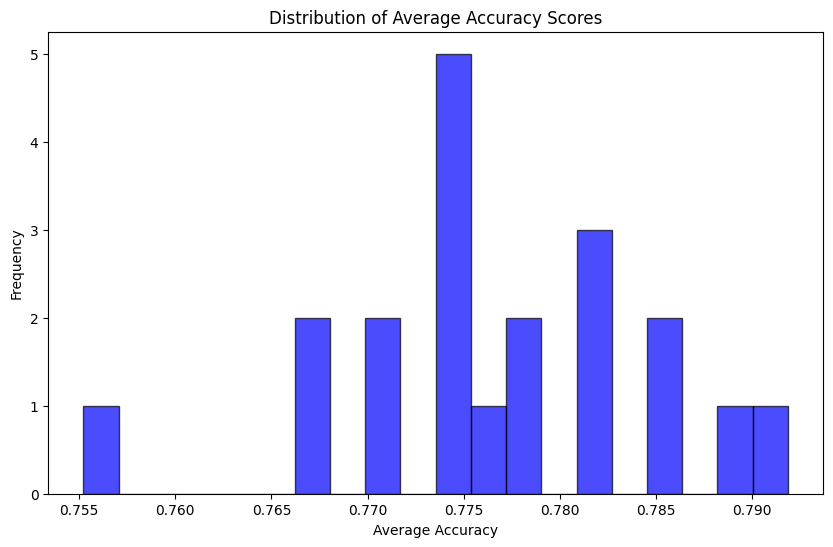

file: beta_data_2_120.csv Average Average Accuracy: 0.7760572390572391 params: {'rf__max_depth': 3, 'rf__max_features': 0.6639830714160453, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 8, 'rf__n_estimators': 143}
Average Accuracy: 0.7810774410774411
Average Accuracy: 0.7882828282828283
Average Accuracy: 0.7954882154882155
Average Accuracy: 0.7918518518518519
Average Accuracy: 0.791986531986532
Average Accuracy: 0.791986531986532
Average Accuracy: 0.7991245791245791
Average Accuracy: 0.7810101010101009
Average Accuracy: 0.7994612794612795
Average Accuracy: 0.7918518518518519
Average Accuracy: 0.7920538720538721
Average Accuracy: 0.8065993265993265
Average Accuracy: 0.7843771043771044
Average Accuracy: 0.780875420875421
Average Accuracy: 0.7993939393939394
Average Accuracy: 0.8066666666666666
Average Accuracy: 0.7992592592592593
Average Accuracy: 0.7991919191919191
Average Accuracy: 0.799057239057239
Average Accuracy: 0.780875420875421


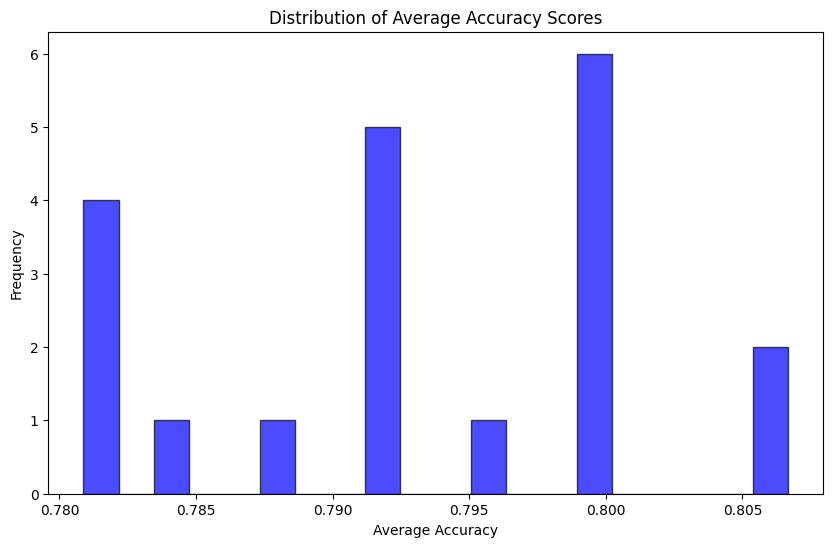

file: beta_data_2_42.csv Average Average Accuracy: 0.7930235690235692 params: {'rf__max_depth': 3, 'rf__max_features': 0.6639830714160453, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 8, 'rf__n_estimators': 143}
Average Accuracy: 0.7882828282828284
Average Accuracy: 0.7770370370370371
Average Accuracy: 0.7958922558922559
Average Accuracy: 0.7954882154882155
Average Accuracy: 0.7956228956228956
Average Accuracy: 0.780942760942761
Average Accuracy: 0.7738047138047139
Average Accuracy: 0.7847811447811448
Average Accuracy: 0.7847138047138047
Average Accuracy: 0.7845791245791247
Average Accuracy: 0.7738720538720538
Average Accuracy: 0.7703703703703704
Average Accuracy: 0.781010101010101
Average Accuracy: 0.7662626262626263
Average Accuracy: 0.7627609427609426
Average Accuracy: 0.7701683501683502
Average Accuracy: 0.7845791245791247
Average Accuracy: 0.7956902356902358
Average Accuracy: 0.7880134680134679
Average Accuracy: 0.7991245791245791


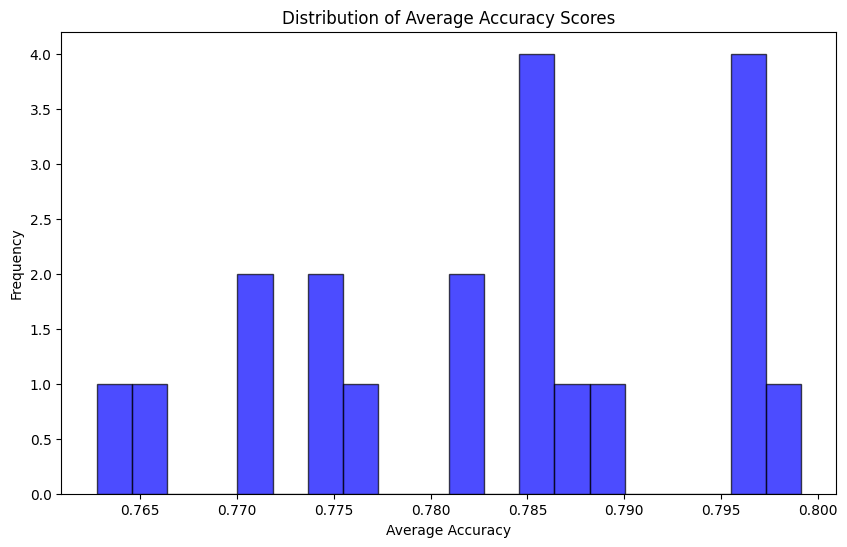

file: beta_data_7_60.csv Average Average Accuracy: 0.7826498316498316 params: {'rf__max_depth': 3, 'rf__max_features': 0.6639830714160453, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 8, 'rf__n_estimators': 143}


In [94]:
# iterate for all the data files in the folder 'beta_dates
for params in rf_params + [means]:
    for file in os.listdir('beta_dates'):
        rf_avg_accuracy_scores = []

        if file == 'true_labels.csv':
            continue

        for i in range(20):
            # Number of splits for K-Fold Cross-Validation
            n_splits = 5
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

            X, y = load_data_cv(data_address='beta_dates/' + file)

            famd = FAMD(n_components=8)
            famd.fit(X)
            X = famd.transform(X)

            # create a pipeline with the best parameters
            pipe = Pipeline([
                ('rf', RandomForestClassifier()),
            ])

            # Perform K-Fold Cross-Validation

            # set the parameters to the mean values
            pipe.set_params(**params)

            accuracy_scores = []
            for train_index, test_index in skf.split(X, y):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Fit the pipeline to the training data
                pipe.fit(X_train, y_train)

                # Make predictions on the test set
                predictions = pipe.predict(X_test)

                # Evaluate the model
                # print(classification_report(y_test, predictions))
                # print("Accuracy:", accuracy_score(y_test, predictions))
                accuracy_scores.append(accuracy_score(y_test, predictions))

            print("Average Accuracy:", np.mean(accuracy_scores))
            rf_avg_accuracy_scores.append(np.mean(accuracy_scores))
        # Create the histogram
        plt.figure(figsize=(10, 6))
        plt.hist(rf_avg_accuracy_scores, bins=20, color='blue', alpha=0.7, edgecolor='black')
        plt.title('Distribution of Average Accuracy Scores')
        plt.xlabel('Average Accuracy')
        plt.ylabel('Frequency')
        plt.show()
        print("file:", file, "Average Average Accuracy:", np.mean(rf_avg_accuracy_scores), "params:", params)

# Logistic Regression Bayesian Optimization

In [50]:
# # Assume load_data function and dataset are defined
# X_train, X_test, y_train, y_test = load_data()

# # Create a pipeline for Logistic Regression
# pipe = Pipeline([
#     ('svd', TruncatedSVD(n_components=5)),
#     ('logreg', LogisticRegression(max_iter=1000)),  # Increased max_iter for convergence
# ])

# penalties = ['l2']
# multi_classes = ['ovr', 'multinomial']
# solvers = ['newton-cg', 'lbfgs', 'sag', 'saga']

# # Define the evaluation function
# def logreg_evaluate(C, penalty, multi_class, solver):
#     penalty = penalties[int(penalty)]
#     multi_class = multi_classes[int(multi_class)]
#     solver = solvers[int(solver)]

#     params = {
#         'logreg__C': C,
#         'logreg__penalty': penalty,
#         'logreg__multi_class': multi_class,
#         'logreg__solver': solver,
#     }
#     pipe.set_params(**params)
#     pipe.fit(X_train, y_train)
#     predictions = pipe.predict(X_test)
#     return accuracy_score(y_test, predictions)

# # Bayesian Optimization
# optimizer = BayesianOptimization(
#     f=logreg_evaluate,
#     pbounds={
#         'C': (0.1, 100),
#         'penalty': (0, len(penalties) - 1),  # Ensuring valid index range
#         'multi_class': (0, len(multi_classes) - 1),  # Ensuring valid index range
#         'solver': (0, len(solvers) - 1),  # Ensuring valid index range
#     },
#     random_state=42
# )

# optimizer.maximize(init_points=5, n_iter=200)

# # After optimization, retrieve and adjust best parameters for pipeline
# best_params = optimizer.max['params']
# best_params_for_pipeline = {
#     'logreg__C': best_params['C'],
#     'logreg__penalty': penalties[int(best_params['penalty'])],
#     'logreg__multi_class': multi_classes[int(best_params['multi_class'])],
#     'logreg__solver': solvers[int(best_params['solver'])],
# }

# # Set the best parameters in the pipeline
# pipe.set_params(**best_params_for_pipeline)
# pipe.fit(X_train, y_train)

# # Predictions and Evaluation
# predictions = pipe.predict(X_test)
# print(classification_report(y_test, predictions))

# # Print best parameters and performance
# print("Best Parameters for Pipeline:", best_params_for_pipeline)
# print("Best Performance:", optimizer.max['target'])


In [45]:
# Number of splits for K-Fold Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

X, y = load_data_cv()

famd = FAMD(n_components=2)
famd.fit(X)
X = famd.transform(X)
imputer = SimpleImputer(strategy='mean')

pipe = Pipeline([
        ('imputer', imputer),  # Impute any NaNs that might be produced by FAMD
        ('lda', LinearDiscriminantAnalysis()),
    ])

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the pipeline to the training data
    pipe.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = pipe.predict(X_test)

    # Evaluate the model
    print(classification_report(y_test, predictions))
    print("Accuracy:", accuracy_score(y_test, predictions))


              precision    recall  f1-score   support

         0.0       1.00      0.29      0.44         7
         1.0       0.77      0.95      0.85        38
         2.0       0.67      0.40      0.50        10

    accuracy                           0.76        55
   macro avg       0.81      0.54      0.60        55
weighted avg       0.78      0.76      0.73        55

Accuracy: 0.7636363636363637
              precision    recall  f1-score   support

         0.0       0.67      0.33      0.44         6
         1.0       0.76      0.89      0.82        38
         2.0       0.57      0.36      0.44        11

    accuracy                           0.73        55
   macro avg       0.66      0.53      0.57        55
weighted avg       0.71      0.73      0.70        55

Accuracy: 0.7272727272727273
              precision    recall  f1-score   support

         0.0       0.67      0.33      0.44         6
         1.0       0.80      0.97      0.88        38
         2.0     

In [21]:
# Number of splits for K-Fold Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

X, y = load_data_cv()

famd = FAMD(n_components=5, random_state=42)
famd.fit(X)
X = famd.transform(X)
imputer = SimpleImputer(strategy='mean')

pipe = Pipeline([
        ('imputer', imputer),  # Impute any NaNs that might be produced by FAMD
        ('qda', QuadraticDiscriminantAnalysis()),
    ])

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the pipeline to the training data
    pipe.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = pipe.predict(X_test)

    # Evaluate the model
    print(classification_report(y_test, predictions))
    print("Accuracy:", accuracy_score(y_test, predictions))


              precision    recall  f1-score   support

         0.0       0.29      0.29      0.29         7
         1.0       0.79      0.68      0.73        38
         2.0       0.40      0.60      0.48        10

    accuracy                           0.62        55
   macro avg       0.49      0.52      0.50        55
weighted avg       0.65      0.62      0.63        55

Accuracy: 0.6181818181818182
              precision    recall  f1-score   support

         0.0       0.50      0.33      0.40         6
         1.0       0.84      0.82      0.83        38
         2.0       0.57      0.73      0.64        11

    accuracy                           0.75        55
   macro avg       0.64      0.63      0.62        55
weighted avg       0.75      0.75      0.74        55

Accuracy: 0.7454545454545455
              precision    recall  f1-score   support

         0.0       0.67      0.33      0.44         6
         1.0       0.78      0.74      0.76        38
         2.0     

In [10]:
# turn FAMD X and y into a csv file with y labeled 'target',
X, y = load_data_cv()
famd = FAMD(n_components=12)
famd.fit(X)
X = famd.transform(X)
X['target'] = y

# turn columns numeric
X = X.apply(pd.to_numeric)

# save the index
# save to csv
X.to_csv('famd_data.csv', index=True)

In [8]:
X, y = load_data_cv()

# add y to X as 'target'
X['target'] = y

# save to csv
X.to_csv('raw_data.csv', index=False)